## 데이터셋 불러오기

In [126]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score, classification_report, roc_curve
import numpy as np
import lightgbm as light
import matplotlib.pyplot as plt
import pdpbox as pdp

# plotly 사용
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import plot

### 데이터셋 불러오기

In [127]:
data_kr = pd.read_csv("C:/Users/kimsdata/Desktop/study/TFT_last/kr_challengers_12.12.450.4196_2022-07-01_matches.csv")
data_euw = pd.read_csv("C:/Users/kimsdata/Desktop/study/TFT_last/euw1_challengers_12.12.450.4196_2022-07-01_matches.csv")
data_na = pd.read_csv("C:/Users/kimsdata/Desktop/study/TFT_last/na1_challengers_12.12.450.4196_2022-07-01_matches.csv")

In [128]:
data_1 = pd.concat([data_kr,data_euw])
data = pd.concat([data_1,data_na])

# EDA

In [129]:
data.head()

,placement,match_id,augment0,augment1,augment2,Set7_Assassin,Set7_Astral,Set7_Bard,Set7_Bruiser,Set7_Cannoneer,...,TFT7_Yasuo_item1,TFT7_Yasuo_item2,TFT7_Yone,TFT7_Yone_item0,TFT7_Yone_item1,TFT7_Yone_item2,TFT7_Zoe,TFT7_Zoe_item0,TFT7_Zoe_item1,TFT7_Zoe_item2
0,7,KR_6011692404,TFT6_Augment_TinyTitans,TFT6_Augment_LudensEcho2,TFT6_Augment_Diversify2,1.0,NaN,NaN,NaN,NaN,...,InfinityEdge,Bloodthirster,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,KR_6011692404,TFT6_Augment_Electrocharge1,TFT6_Augment_TradeSectorPlus,TFT6_Augment_PortableForge,0.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,KR_6011692404,TFT6_Augment_ThrillOfTheHunt1,TFT7_Augment_MikaelsGift,TFT7_Augment_UrfsGrabBag1,0.0,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,GuinsoosRageblade,ArchangelsStaff,NaN
3,3,KR_6011692404,TFT6_Augment_ItemGrabBag1,TFT6_Augment_SecondWind2,TFT7_Augment_DragonHorde,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,KR_6011692404,TFT6_Augment_CelestialBlessing1,TFT6_Augment_SunfireBoard,TFT6_Augment_Diversify2,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> 컬럼에 아이템이 들어가니 너무많은 컬럼이 있어 드랍하고 단순히 시너지와 증강체, 캐릭터만 가져오기로 결정.

> 목적  

- 현재 유행하는 시너지, 증강체, 캐릭터를 분석하고 1~4등을 1, 5~8등을 0으로 두어 새로운 컬럼(순위방어 유무)을 만들고 순방여부를 통해 새로운 데이터가 들어왔을때 순위방어를 예측(분류)하는 모델을 만든다.  
  
> 더해서 시각화와 모델을 통해  
  
- 순위방어가 잘되는 오버벨랜스 증강체나 시너지 유닛이 있을 것이다(가설)  
가설을 통해 캐릭터 및 시너지의 오버밸런스 여부를 판단하고 다음패치에 어떤 조정이 필요한지 알아보고자 한다.

> 데이터 누수 방지를 위해

- 타겟 데이터(ranking defense)와 타겟 데이터를 만든 컬럼(placement)을 제거하고 모델을 학습시킨다. -타겟 데이터 리키지 방지
- 데이터를 train과 val, test로 나누어 train으로만 훈련시키기. - 데이터 리키지 방지

  
> 가설 해결

오버 밸런스 목록  

- pdpplot과 특성 중요도로 살펴 보았을 때 순위방어율로 살펴본 결과 몇개의 시너지와 유닛이 높은 수치를 가지고 있다.

1. 위 결과를 토대로 유닛은 야스오, 니코, 사이펜을 너프한다.  

>야스오 - 스텟 너프(시너지 상관없이 자체 순방율이 높음)  
사이펜 - 시너지의 영향보다 유닛 자체가 쌔므로 이를 너프하고 시너지를 버프하는쪽으로 패치  
오른- 사이펜 너프로인한 간접너프
탈론- 길드너프 (자야 간접 너프)  
코르키 - 축제 너프(코르키 보다는 시너지가 더 큰 영향을 미침)  
시오유 - 유지(니코 너프로 인한 간접 너프)  

2. 시너지는 축제, 길드, 빛비늘을 너프한다.  
>빛비늘-9빛비늘만 너프  
길드 - 길드 자체 시너지를 너프 길드를 사용하는 조합들이 높은 순방률을 보임  
축제 - 축제 시너지 자체가 순방률이 높음 따라서 너프  

모델을 학습한 후에 베이스라인보다 잘 나왔나요? 그렇지 않다면 그 이유는 무엇일까요? -잘나왔다 
모델 성능 개선을 위해 어떤 방법을 적용했나요? 그 방법을 선택한 이유는 무엇인가요? - 베이지안으로 하이퍼 파라미터 튜닝을 진행하였다.
최종 모델과 일반화 성능에 관해 설명하세요. - test데이터로 확인했을때 성능이 크게 달라지지 않았다. 일반화 성능이 괜찮은 모델로 판단된다.
모델이 관측치를 예측하기 위해서 어떤 특성을 활용했나요? - 아이템을 제외한 모든 특성을 사용하였다. 모두 타겟에 영향을 미치는 요소이고 당장은 아니더라도 추후에 새로운 조합이나 패치를 통해 데이터의 양상이 달라질 수 있기 떄문이다.

In [130]:
df = data.copy()
# item이란 이름을 포함한 컬럼 제거 컬럼이 92개로 준것을 확인
df.drop(columns=df.columns[df.columns.str.contains("item")], inplace=True)

In [131]:
# str로 마지막 번째 인자에 접근가능
df.augment0 = df.augment0.str.split("_").str[-1]
df.augment1 = df.augment1.str.split("_").str[-1]
df.augment2 = df.augment2.str.split("_").str[-1]

In [132]:
df.head()

,placement,match_id,augment0,augment1,augment2,Set7_Assassin,Set7_Astral,Set7_Bard,Set7_Bruiser,Set7_Cannoneer,...,TFT7_TrainerDragon,TFT7_Tristana,TFT7_Twitch,TFT7_Varus,TFT7_Vladimir,TFT7_Volibear,TFT7_Xayah,TFT7_Yasuo,TFT7_Yone,TFT7_Zoe
0,7,KR_6011692404,TinyTitans,LudensEcho2,Diversify2,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,1,KR_6011692404,Electrocharge1,TradeSectorPlus,PortableForge,0.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
2,8,KR_6011692404,ThrillOfTheHunt1,MikaelsGift,UrfsGrabBag1,0.0,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,3,KR_6011692404,ItemGrabBag1,SecondWind2,DragonHorde,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,5,KR_6011692404,CelestialBlessing1,SunfireBoard,Diversify2,NaN,NaN,NaN,NaN,2.0,...,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134696 entries, 0 to 49143
Data columns (total 92 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   placement           134696 non-null  int64  
 1   match_id            134696 non-null  object 
 2   augment0            134678 non-null  object 
 3   augment1            134578 non-null  object 
 4   augment2            134043 non-null  object 
 5   Set7_Assassin       57608 non-null   float64
 6   Set7_Astral         29854 non-null   float64
 7   Set7_Bard           38724 non-null   float64
 8   Set7_Bruiser        87293 non-null   float64
 9   Set7_Cannoneer      19130 non-null   float64
 10  Set7_Cavalier       37940 non-null   float64
 11  Set7_Dragon         97006 non-null   float64
 12  Set7_Dragonmancer   58898 non-null   float64
 13  Set7_Evoker         48571 non-null   float64
 14  Set7_Guardian       39935 non-null   float64
 15  Set7_Guild          83668 non-null 

In [134]:
# 결측치중에 증강체를 선택하지 않은 경우에는 제대로된 게임이 아니라고 판단하여 제거 나머지 시너지의 nan값엔 0으로 채움
df.isnull().sum()

placement             0
match_id              0
augment0             18
augment1            118
augment2            653
                  ...  
TFT7_Volibear    127463
TFT7_Xayah       109391
TFT7_Yasuo        95573
TFT7_Yone        127302
TFT7_Zoe         119989
Length: 92, dtype: int64

In [135]:
df.dropna(subset=['augment0','augment1','augment2'],inplace=True)

In [136]:
df.placement.value_counts()

5    16830
4    16830
3    16830
2    16830
1    16830
6    16827
7    16790
8    16276
Name: placement, dtype: int64

In [137]:
# placement를 순방일때 1 아닐때 0으로 변환해서 ranking_defense 생성.
# target = "ranking defense" df.ranking_defense 으로 하면 에러남
df["ranking defense"] = pd.cut(df.placement, 2, labels = [1,0])


In [138]:
ranking_rate= df["ranking defense"].value_counts(normalize=True)

In [139]:
fig = px.pie(ranking_rate, values=ranking_rate.values, names={'1': "Success", '2': "Fail"}, hole=.3, color_discrete_sequence=px.colors.sequential.RdBu,width=800)
fig.update_traces(pull=[0.06,0.06],textposition='inside', textinfo='percent+label')
fig.update_layout(
    legend_title_text='defense',
    title=dict(
        text='Ranking Defense',
        x=0.5,
        y=0.95,
        font=dict(
            family="Arial",
            size=30,
            color="#000000"           
        )))
fig.show()

In [140]:
# 시너지
df.columns[df.columns.str.contains("Set7")]

Index(['Set7_Assassin', 'Set7_Astral', 'Set7_Bard', 'Set7_Bruiser',
       'Set7_Cannoneer', 'Set7_Cavalier', 'Set7_Dragon', 'Set7_Dragonmancer',
       'Set7_Evoker', 'Set7_Guardian', 'Set7_Guild', 'Set7_Jade',
       'Set7_Legend', 'Set7_Mage', 'Set7_Mirage', 'Set7_Mystic',
       'Set7_Ragewing', 'Set7_Revel', 'Set7_Scalescorn', 'Set7_Shapeshifter',
       'Set7_Shimmerscale', 'Set7_SpellThief', 'Set7_Starcaller',
       'Set7_Swiftshot', 'Set7_Tempest', 'Set7_Trainer', 'Set7_Warrior',
       'Set7_Whispers'],
      dtype='object')

In [141]:
# 캐릭터
df.columns[df.columns.str.contains("TFT7")]

Index(['TFT7_Aatrox', 'TFT7_Anivia', 'TFT7_AoShin', 'TFT7_Ashe',
       'TFT7_AurelionSol', 'TFT7_Bard', 'TFT7_Braum', 'TFT7_Corki',
       'TFT7_Diana', 'TFT7_DragonBlue', 'TFT7_DragonGold', 'TFT7_DragonGreen',
       'TFT7_DragonPurple', 'TFT7_Elise', 'TFT7_Ezreal', 'TFT7_Gnar',
       'TFT7_Hecarim', 'TFT7_Heimerdinger', 'TFT7_Illaoi', 'TFT7_Jinx',
       'TFT7_Karma', 'TFT7_Kayn', 'TFT7_LeeSin', 'TFT7_Leona', 'TFT7_Lillia',
       'TFT7_Lulu', 'TFT7_Nami', 'TFT7_Neeko', 'TFT7_Nidalee', 'TFT7_Nunu',
       'TFT7_Olaf', 'TFT7_Ornn', 'TFT7_Pyke', 'TFT7_Qiyana', 'TFT7_Ryze',
       'TFT7_Sejuani', 'TFT7_Senna', 'TFT7_Sett', 'TFT7_Shen', 'TFT7_Shyvana',
       'TFT7_Skarner', 'TFT7_Sona', 'TFT7_Soraka', 'TFT7_Swain', 'TFT7_Sylas',
       'TFT7_TahmKench', 'TFT7_Talon', 'TFT7_Taric', 'TFT7_Thresh',
       'TFT7_TrainerDragon', 'TFT7_Tristana', 'TFT7_Twitch', 'TFT7_Varus',
       'TFT7_Vladimir', 'TFT7_Volibear', 'TFT7_Xayah', 'TFT7_Yasuo',
       'TFT7_Yone', 'TFT7_Zoe'],
      dtype='ob

In [142]:
augment0_top = df.filter(regex=r'placement|augment0').melt('placement', value_name='Augment0')
dct = {'v_count': ('Augment0', 'count'), 'agg_placement': ('placement', 'mean')}
augment0_rank_df = augment0_top.groupby('Augment0', as_index=False).agg(**dct).sort_values(by='agg_placement')
augment0_rank_df['agg_placement'] = augment0_rank_df['agg_placement'].round(2)

In [143]:
# 평균등수 순 - 적은 수의 선택에도 불구하고 높은 순방률을 보여준다.
augment0_sel = augment0_rank_df[augment0_rank_df.v_count > 100].head(10)

> 증강체별로 순방에 얼마나 영향을 미치는지 확인하려면 약 200여개의 컬럼이 추가로 생성되고 각 증강체별로 등장 확률이 다르므로 시각화를 통해 증강체 선택 라운드마다 어떤 증강체를 선호하고 이 증강체가 순방률에 어떤 영향을 끼치는지까지만 알아보고자한다.

In [144]:
augment0_sel

,Augment0,v_count,agg_placement
136,RevelEmblem2,478,3.05
183,Twins2,532,3.36
184,Twins3,162,3.77
75,GadgetExpert,1437,3.79
166,ThinkFast,137,3.90
14,BestFriends2,1355,3.91
5,AssassinEmblem2,385,3.95
34,CavalierEmblem2,352,3.97
94,JadeTrait2,274,3.97
123,PortableForge,5855,3.98


In [145]:
fig = px.treemap(augment0_sel, path=[px.Constant('Augument0_1-4_Round'), 'Augment0', 'v_count','agg_placement'], 
                values='agg_placement', color='v_count', color_continuous_scale='RdBu',
                color_continuous_midpoint=np.average(augment0_sel['v_count'], weights=augment0_sel['agg_placement']),width=1200, height=500)

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [146]:
# # 100개 이하는 뺴야되지 않을까?
# fig, axes =plt.subplots(1,2, figsize=(30,10))
# sns.barplot(data = augment0_sel, x='agg_placement', y='Augment0', ax=axes[0], palette="coolwarm")
# sns.barplot(data = augment0_sel, x='v_count', y='Augment0', ax=axes[1], palette="coolwarm")

# plt.suptitle("Top 10 Augment(100_upper)-(1-4round)", fontsize=30, y=1.05)
# axes[0].set_title("Ranking Defense Rate",fontsize=25, y=1.01)
# axes[1].set_title("Augmented Selections",fontsize=25, y=1.01)
# fig.tight_layout()
# plt.show()

> 매치데이터 중 1-4 라운드 증강체 선택이 100개 이하인것을 제외하고 그래프를 시각화 한것입니다. 보이는 것과 같이 RevelEmblem2가 2.9, Twins2가 3.4대로 상대적으로 적은 비율을 차지하고 있음에도 매우 높은 순위를 기록하고 있습니다. RevelEmblem2 순방률이 높은 이유는 초반에 축제시너지가 활용하기 쉬우면서도 강력해 체력관리가 필요 이상으로 됨으로 수치를 조정할 필요가 있어 보입니다. 의외로 제일 마지막인 PortableForge가 높은 선택률을 가지고 있습니다. 다른 증강체들이 순방률이 좋음에도 불구하고 PortableForge를 선택하는 이유는 초반에 무난하면서도 어느정도 좋은 증강체를 가야 후반 빌드업을 유연하게 컨트롤 가능하기 때문입니다.

> 

In [147]:
augment1_top = df.filter(regex=r'placement|augment1').melt('placement', value_name='Augment1')
dct = {'v_count': ('Augment1', 'count'), 'agg_placement': ('placement', 'mean')}
augment1_rank_df = augment1_top.groupby('Augment1', as_index=False).agg(**dct).sort_values(by='agg_placement')
augment1_rank_df['agg_placement'] = augment1_rank_df['agg_placement'].round(2)

In [148]:
augment1_rank_df

,Augment1,v_count,agg_placement
136,RevelPartyFavorsHR,2,3.00
134,RevelEmblem2,245,3.15
173,Traitless3,18,3.17
171,Traitless1,27,3.26
3,AssassinEmblem2,123,3.49
...,...,...,...
37,ClutteredMind,140,5.49
182,WarriorEmblem,37,5.57
65,EvokerEssenceTheft,19,5.58
150,ShimmerscaleSpending,28,6.25


In [149]:
# 평균등수 순 - 적은 수의 선택에도 불구하고 높은 순방률을 보여준다.
augment1_sel = augment1_rank_df[augment1_rank_df.v_count > 100].head(10)

In [150]:
fig = px.treemap(augment1_sel, path=[px.Constant('Augument1_3-3_Round'), 'Augment1', 'v_count','agg_placement'], 
                values='agg_placement', color='v_count', color_continuous_scale='RdBu',
                color_continuous_midpoint=np.average(augment1_sel['v_count'], weights=augment1_sel['agg_placement']),width=1200, height=500)

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [151]:
# # 100개 이하는 뺴야되지 않을까?
# fig, axes =plt.subplots(1,2, figsize=(30,10))
# sns.barplot(data = augment1_sel, x='agg_placement', y='Augment1', ax=axes[0], palette="coolwarm")
# sns.barplot(data = augment1_sel, x='v_count', y='Augment1', ax=axes[1], palette="coolwarm")

# plt.suptitle("Top 10 Augment(100_upper)-(3-3round)", fontsize=30, y=1.05)
# axes[0].set_title("Ranking Defense Rate",fontsize=25, y=1.01)
# axes[1].set_title("Augmented Selections",fontsize=25, y=1.01)
# fig.tight_layout()
# plt.show()

> 매치데이터 중 3-3 라운드 증강체 선택이 100개 이하인것을 제외하고 그래프를 시각화 한것입니다. 1-4와 같이 RevelEmblem2가 2.9대로 상대적으로 적은 비율을 차지하고 있음에도 매우 높은 순위를 기록하고 있습니다. 또한 BestFriends2가 높은 선택률을 가지고 있습니다.(Diversify = 다른태생). 위에 기술한 이유와 마찬가지로 후반 빌드업을 위해 적절한 보편적인 증강체를 선호하는것을 볼 수 있습니다.

In [152]:
augment2_top = df.filter(regex=r'placement|augment2').melt('placement', value_name='Augment2')
dct = {'v_count': ('Augment2', 'count'), 'agg_placement': ('placement', 'mean')}
augment2_rank_df = augment2_top.groupby('Augment2', as_index=False).agg(**dct).sort_values(by='agg_placement')
augment2_rank_df['agg_placement'] = augment2_rank_df['agg_placement'].round(2)

In [153]:
# 평균등수 순 - 적은 수의 선택에도 불구하고 높은 순방률을 보여준다.
augment2_sel = augment2_rank_df[augment2_rank_df.v_count > 100].head(10)

In [154]:
augment2_sel

,Augment2,v_count,agg_placement
40,CyberneticImplants3,606,3.95
120,RevelPartyFavors,503,3.95
147,TheGoldenEgg,941,3.99
13,BestFriends3,646,4.03
39,CyberneticImplants2,2510,4.04
44,CyberneticUplink1,332,4.05
51,Diversify2,4921,4.05
12,BestFriends2,2773,4.06
119,RevelEmblem2,184,4.06
15,BigFriend2,1851,4.06


In [155]:
fig = px.treemap(augment2_sel, path=[px.Constant('Augument2_4-6_Round'), 'Augment2', 'v_count','agg_placement'], 
                values='agg_placement', color='v_count', color_continuous_scale='RdBu',
                color_continuous_midpoint=np.average(augment2_sel['v_count'], weights=augment2_sel['agg_placement']),width=1200, height=500)

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [156]:
# # 100개 이하는 뺴야되지 않을까?
# fig, axes =plt.subplots(1,2, figsize=(30,10))
# sns.barplot(data = augment2_sel, x='agg_placement', y='Augment2', ax=axes[0], palette="coolwarm")
# sns.barplot(data = augment2_sel, x='v_count', y='Augment2', ax=axes[1], palette="coolwarm")

# plt.suptitle("Top 10 Augment(100_upper)-(4-6round)", fontsize=30, y=1.05)
# axes[0].set_title("Ranking Defense Rate",fontsize=25, y=1.01)
# axes[1].set_title("Augmented Selections",fontsize=25, y=1.01)
# fig.tight_layout()
# plt.show()

> 매치데이터 중 4-6 라운드 증강체 선택이 100개 이하인것을 제외하고 그래프를 시각화 한것입니다. 압도적으로 높은 순방률을 가진 증강체는 없으나 BestFriends2, Diversify2가 높은 선택률을 가지고 있습니다. 전반적으로 보았을때 특정 시너지에서 작용하는 증강체가 아닌 보편적인 증강체를 선호하는 것을 볼 수 있습니다.

> 종합적으로 봤을때 증강체 부분에서 오버밸런스로 판단되어 조정이 필요한것은 RevelEmblem2 정도가 되고 twin2같은 경우 같은 유닛을 사용해야된다는 조건 때문에 2번째 증강체에선 순방률이 떨어져 별다른 패치가 필요없어 보인다.

## 시너지 목록
>SpellThief : 주문도둑(최대1)  
Starcaller : 별 부르미(최대1)  
Bard : 음유시인(최대1)  
Assassin : 암살자  
Astral : 별  
Bruiser : 난동꾼  
Cannoneer : 포병대  
Cavalier : 기병대  
Dragon : 용  
Dragonmancer : 용술사  
Evoker : 깨달은 자  
Guardian : 수호자  
Guild : 길드  
Jade : 비취  
Legend : 전설  
Mage : 요술사  
Mirage : 신기루  
Mystic : 신비술사  
Ragewing : 분노날개  
Scalescorn : 비늘혐오자  
Shapeshifter : 형상변환자  
Shimmerscale : 빛비늘  
Swiftshot : 민첩사수  
Tempest : 폭풍  
Warrior : 전사  
Whispers : 속삭임  
Trainer : 조련사  
Revel : 축제  


In [157]:
# 초기화 안해주면 중복값 생김
rank_df_result = pd.DataFrame()
for i in df.columns[df.columns.str.contains("Set7")]:
    sel = df.filter(['placement',i]).melt('placement', value_name='synergy')
    dct = {'v_count': ('synergy', 'count'), 'agg_placement': ('placement', 'mean')}
    rank_df = sel.groupby('synergy', as_index=False).agg(**dct).sort_values(by='agg_placement')
    rank_df['agg_placement'] = rank_df['agg_placement'].round(2)
    rank_df['traits'] = i
    # 리스트 형식으로 해줘야 concat됨 pd.concat([a,b])
    rank_df_result = pd.concat([rank_df_result, rank_df], ignore_index=True)
rank_df_result.traits = rank_df_result.traits.str.split("_").str[-1]

In [158]:
# 여기서 시너지를 발동시키기 힘든기준을 v_count과 agg_placement로 판별 1000이상이면서 4 등 이상으로!
rank_df_result_top= rank_df_result[(rank_df_result.v_count >1000) & (rank_df_result.agg_placement <=4)&(rank_df_result.synergy >0)].sort_values(by='synergy')
rank_df_result_top

,synergy,v_count,agg_placement,traits
8,1.0,38720,3.51,Bard
89,1.0,14703,3.84,SpellThief
90,1.0,22416,3.66,Starcaller
64,2.0,7936,3.65,Mystic
95,2.0,5211,3.73,Tempest
0,3.0,2160,3.67,Assassin
46,3.0,4485,3.91,Jade
80,3.0,1585,3.79,Shapeshifter
41,4.0,4248,3.85,Guild
58,4.0,2141,4.00,Mirage


In [159]:
# fig = px.treemap(rank_df_result_top, path=[px.Constant('Synergy'),'traits', 'synergy','v_count'], 
#                 values='agg_placement', color='v_count', color_continuous_scale='RdBu',
#                 color_continuous_midpoint=np.average(rank_df_result_top['v_count'], weights=rank_df_result_top['agg_placement']))

# fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
# fig.show()

In [160]:
fig = px.bar(rank_df_result_top, x="agg_placement",y="traits", color="traits",
             text="v_count",title="Rank Defense By synergy", color_discrete_sequence=px.colors.qualitative.Safe,
             width=1400, height=800,opacity=0.8, facet_col='synergy')
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()


> 주문도둑(조이), 음유시인(바드), 별부르미(소라카)는 단독 특성(언급한 챔프 1개만 있어도 활성화)이라 높은 사용율을 보인다. 길드는 길드챔피언 하나당 시너지가 1단계씩 증가하므로 마찬가지로 높은 사용율과 순방율을 보이고 있고 이는 길드 시너지인 라이즈, 탈론과 길드 시너지(트위치)를 통해 다른 유닛들을 강화(트위치+자야)하여 사용하는 덱 때문인것으로 보인다. 추후에 살펴보겠지만 자야(분노날개)의 시너지의 순방률이 낮음에도 불구하고 4등 초반인 괜찮은 순방률을 가지고있다. 가장 높은 순방률을 보이는것은 Shummerscale 4시너지(9 빛비늘), Revel 4시너지(4축제)인데 위에 언급한 축제 시너지 증강체와 맞물린다. 

In [161]:
df[df.TFT7_Xayah>0], df[(df.TFT7_Xayah>0) & (df.Set7_Guild>0)]

(       placement        match_id          augment0            augment1  \
 6              4   KR_6011692404         AxiomArc1        BestFriends2   
 7              2   KR_6011692404  ThrillOfTheHunt1           Ascension   
 9              3   KR_6014875338    RagewingScorch         SecondWind1   
 12             1   KR_6014875338     PortableForge  ShimmerscaleEmblem   
 22             1   KR_6015646619     CavalierTrait            Weakspot   
 ...          ...             ...               ...                 ...   
 49096          4  NA1_4365175315       SecondWind2       PortableForge   
 49109          4  NA1_4365417057          TrueTwos          Diversify2   
 49127          7  NA1_4362303052       SecondWind1        TempestTrait   
 49132          4  NA1_4362258997  CyberneticShell3  CelestialBlessing1   
 49141          4  NA1_4362236493    SwiftshotTrait        BruiserTrait   
 
                 augment2  Set7_Assassin  Set7_Astral  Set7_Bard  Set7_Bruiser  \
 6             S

In [162]:
df.TFT7_Xayah[(df.TFT7_Xayah>0) & (df.Set7_Guild>0)].value_counts()

2.0    16873
1.0     2990
3.0      606
Name: TFT7_Xayah, dtype: int64

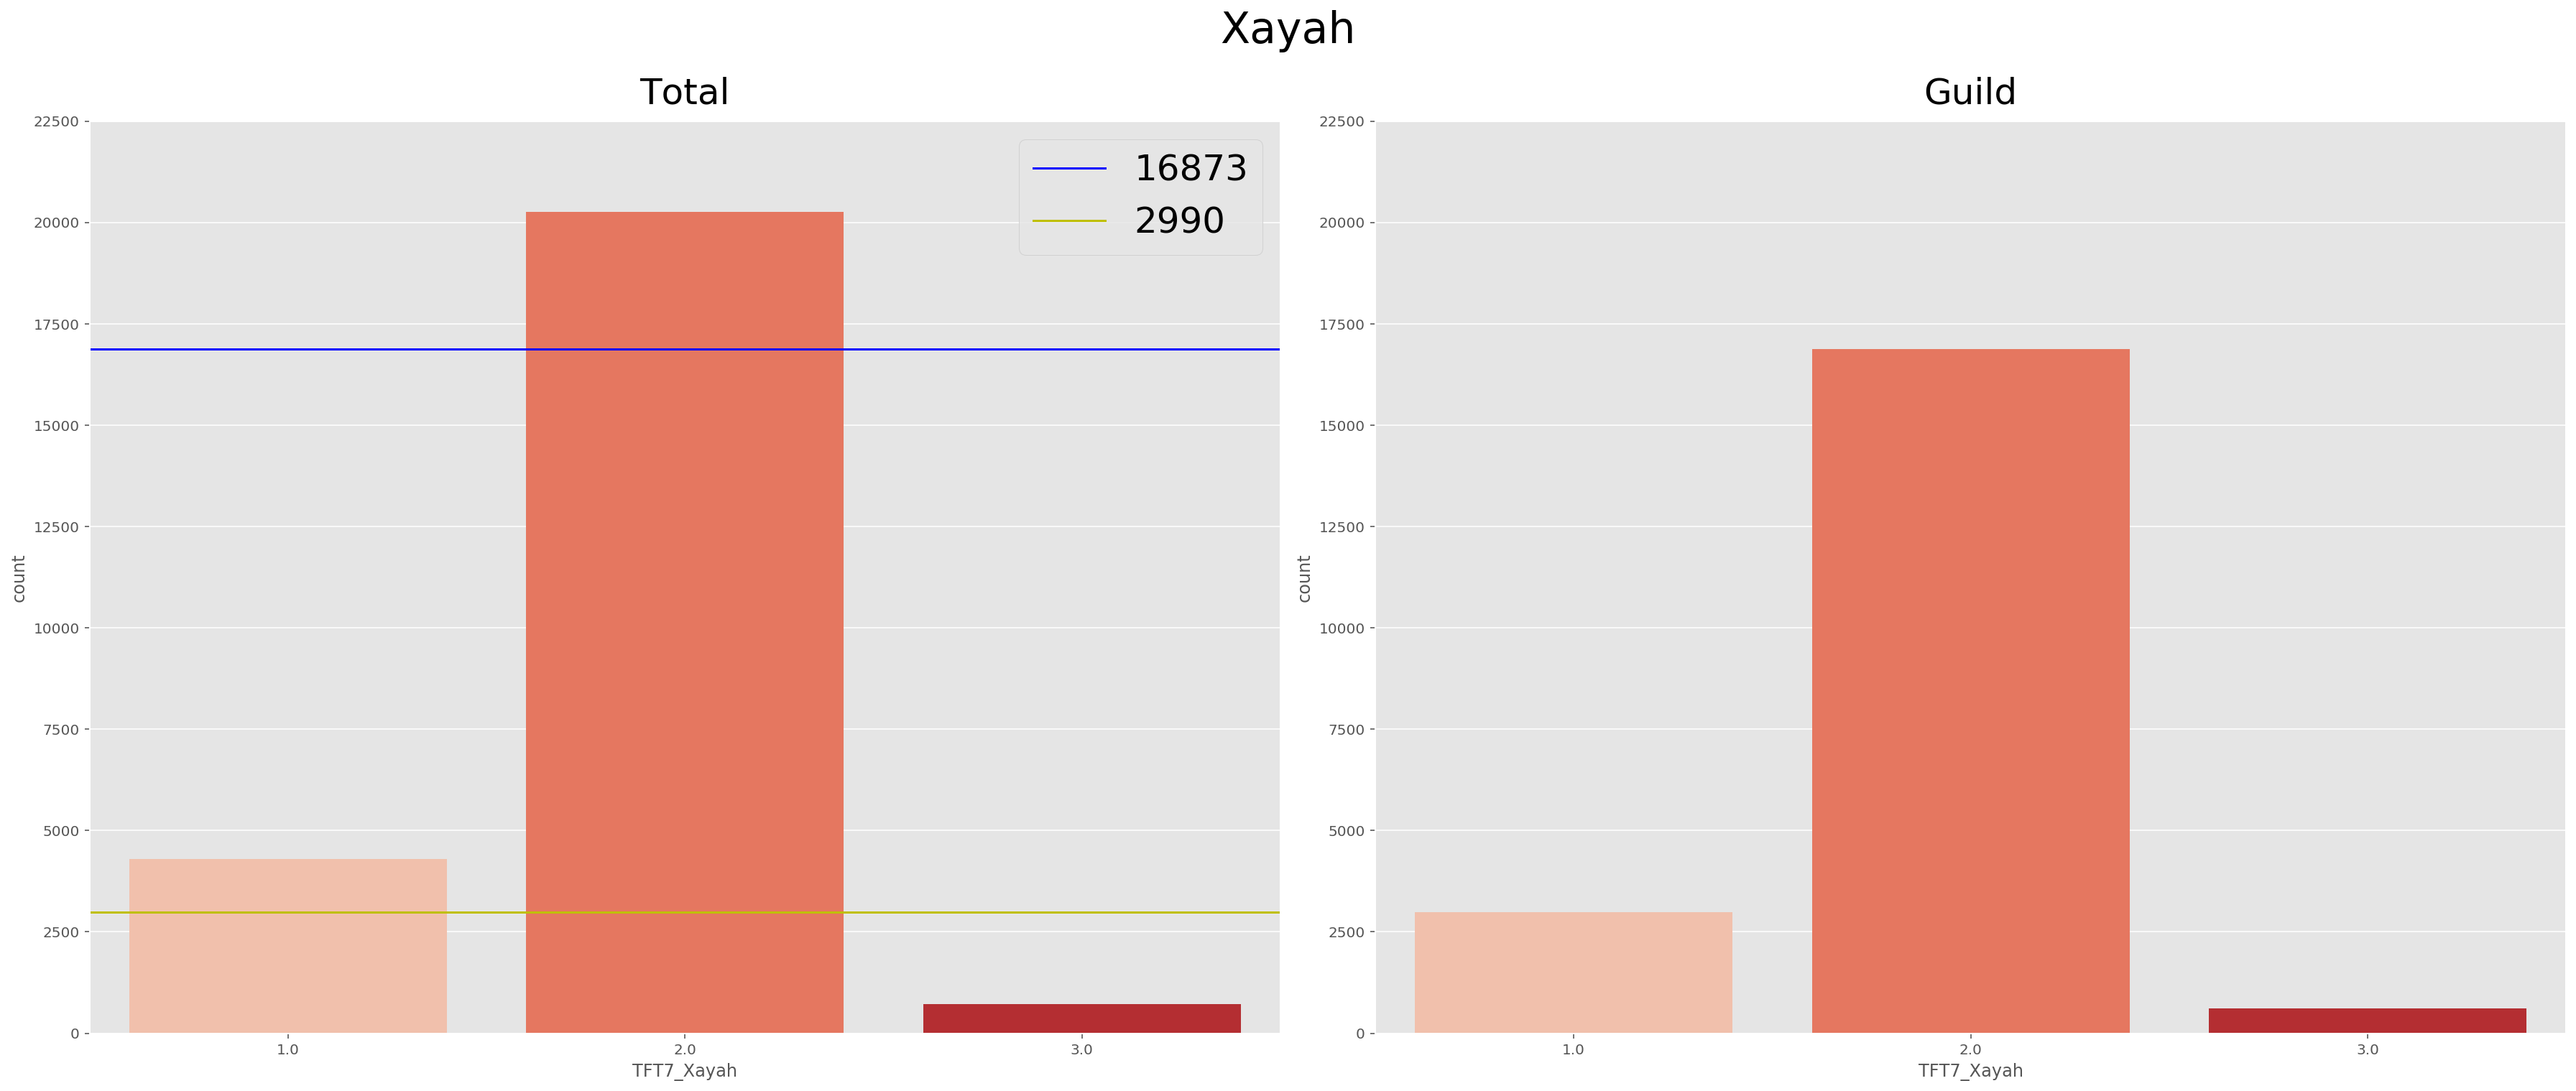

In [163]:
from cProfile import label


fig, axes =plt.subplots(1,2, figsize=(25,10))
sns.countplot(data = df[df.TFT7_Xayah>0], x='TFT7_Xayah', ax=axes[0], palette="Reds")
sns.countplot(data = df[(df.TFT7_Xayah>0) & (df.Set7_Guild>0)], x='TFT7_Xayah', ax=axes[1], palette="Reds")
axes[0].axhline(16873, color= "b", label= "16873")
axes[0].axhline(2990, color= "y", label= "2990")
axes[0].legend(fontsize= 25)

plt.suptitle("Xayah", fontsize=30, y=1.05)
axes[0].set_title("Total",fontsize=25, y=1.01)
axes[1].set_title("Guild",fontsize=25, y=1.01)

axes[0].set_yticks(np.arange(0, 25000, 2500))
axes[1].set_yticks(np.arange(0, 25000, 2500))
fig.tight_layout()
plt.show()

> 보이는것과 같이 상당수의 자야가 들어간 게임에 길드시너지가 활용된것을 알 수 있다. 다른 4코스트(탈론 제외)를 길드시너지와 같이 활용했을 때는 낮은 순방율을 보인다.

In [164]:
# 초기화 안해주면 중복값 생김
rank_df_result_unit = pd.DataFrame()
for i in df.columns[df.columns.str.contains("TFT7")]:
    sel = df.filter(['placement',i]).melt('placement', value_name='star')
    dct = {'v_count': ('star','count'),'agg_placement': ('placement', 'mean')}
    rank_df_unit = sel.groupby('star', as_index=False).agg(**dct).sort_values(by='agg_placement')
    rank_df_unit['agg_placement'] = rank_df_unit['agg_placement'].round(2)
    rank_df_unit['unit'] = i
    # 리스트 형식으로 해줘야 concat됨 pd.concat([a,b])
    rank_df_result_unit = pd.concat([rank_df_result_unit, rank_df_unit], ignore_index=True)
rank_df_result_unit.unit = rank_df_result_unit.unit.str.split("_").str[-1]

In [165]:
# 500기준으로 4 이상만  4성은 욤욤이 하나이고 랭킹이 높지않으므로 제거
rank_df_result_unit_top = rank_df_result_unit[(rank_df_result_unit.v_count >=500)&(rank_df_result_unit.agg_placement <=4) & (rank_df_result_unit.star <=3)].sort_values(by='star')
rank_df_result_unit_top

,star,v_count,agg_placement,unit
176,2.0,5506,2.57,Zoe
7,2.0,2898,2.46,AoShin
16,2.0,12803,2.48,Bard
34,2.0,22211,3.91,DragonGreen
37,2.0,26328,3.74,DragonPurple
139,2.0,28537,3.84,Talon
82,2.0,28217,3.81,Neeko
170,2.0,15816,2.45,Yasuo
94,2.0,38901,3.74,Ornn
97,2.0,9199,2.57,Pyke


In [166]:
fig = px.bar(rank_df_result_unit_top, x="agg_placement",y="unit", color="unit", text="v_count",
             title="Rank Defense By Unit", color_discrete_sequence=px.colors.qualitative.Safe, width=1200, height=800,opacity=0.8, facet_col='star')
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

> 500게임 기준(너무 낮은 게임수는 등장할 빈도가 낮으므로-ex)5코스트 3성, 10코스트 3성)으로 5코스트 기물 조이 야스오 소라카 파이크 바드의 순방률은 크게 차이 나지 않지만 야스오가 다른 기물에 비해 상당히 많은 게임에 사용되면서도 시너지도 괜찮은 순방률도 유지하는 것을 알 수 있다. TFF특성상 코스트별 유닛갯수가 정해져있어 일정개수 이상은 등장하지 않는다. 4코스트 유닛 중 2성으로는 오른(폭풍, 난동꾼), 니코(비취,형상변환자), 탈론(길드, 암살자)이 좋은 순방률을 보이고있는데 이 유닛들의 시너지 또한 좋은 순방률을 가지고 있다. 용은 사이펜(속삭임,난동꾼)같은 경우 시너지가 둘 다 순위권에 없는데도 순방률이 높다. 이는 사이펜 자체의 성능이 좋다고 판단된다. 시오유(비취, 신비술사)의 경우 시너지 둘다 상위권이여서 시너지와의 관계를 분석해볼 필요가 있다.

> 자야, 코르키는 2성 구간에서는 순방률 안에 들지 못하지만 3성이 되는 시점에서 압도적으로 높은 승률을 자랑하는 것을 볼 수 있다. 축제 시너지관련 증강체가 높은 순방률을 보여주었지만 코르키(축제,포병) 자체가 좋다고 볼수없는 근거가 된다. 따라서 코르키와 스탯 너프는 필요없어 보인다. 그러나 자야 같은 경우 관련 증강체나 시너지가 없음에도 높은 성능을 내어 스탯 너프가 필요해 보인다. 추가적으로 자야를 너프하면 관련 시너지인 분노날개의 순방률이 더 떨어질 것이므로 적정한 상향이 필요한 것으로 보인다.

>> 4코스트 유닛 3성보다는 상대적으로 달성하기 쉬운 야스오(신기루)와 탈론(암살자, 길드), 시오유(비취, 신비술사), 니코(비취, 형상변환자)가 오버밸런스인가에 대해 아래에서 시각화를하여 좀 더 알아볼것이다.

# 데이터 

In [167]:
# placement로 타겟데이터를 만든것임으로 드랍.
df.drop(columns=["placement","match_id"], inplace=True)
train_t, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train_t, test_size=0.2, random_state=42)
target = 'ranking defense'
features = df.drop(columns=[target]).columns
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [168]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((85787, 90), (85787,), (21447, 90), (21447,), (26809, 90), (26809,))

> 정확한 하게 순방여부를 예측해야 하기때문에 ROC_AUC를 사용

In [169]:
# 베이스 모델
from sklearn.metrics import accuracy_score

base = y_train.mode()[0]
baseline = len(y_train) * [base]
baseline_roc = roc_auc_score(y_train, baseline)
print(f'기준모델의 roc_auc_score {baseline_roc.round(3)} 입니다')



기준모델의 roc_auc_score 0.5 입니다


In [170]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from category_encoders import OrdinalEncoder, OneHotEncoder
from scipy.stats.distributions import uniform
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from scipy.stats.distributions import uniform
from sklearn.linear_model import LogisticRegression

## Logistic

In [171]:
from sklearn import metrics


logis = make_pipeline(OneHotEncoder(),
                     SimpleImputer(strategy='constant', fill_value=0),
                     LogisticRegression(max_iter=3000, random_state=42)
)

logis.fit(X_train, y_train)
y_pred_logis = logis.predict(X_val)
y_pred_roc_logis = logis.predict_proba(X_val)[:,1]
y_pred_test_logis = logis.predict(X_test)
y_pred_roc_test_logis = logis.predict_proba(X_test)[:,1]
print(classification_report(y_val, y_pred_logis))
print("검증 정확도", logis.score(X_val, y_val))
print("검증 f1_score", f1_score(y_val, y_pred_logis))
print("검증 roc_auc score", roc_auc_score(y_val, y_pred_roc_logis))
print("테스트 f1_score", f1_score(y_test, y_pred_test_logis))
print("테스트 roc_auc score", roc_auc_score(y_test, y_pred_roc_test_logis))


              precision    recall  f1-score   support

           0       0.82      0.82      0.82     10668
           1       0.82      0.83      0.82     10779

    accuracy                           0.82     21447
   macro avg       0.82      0.82      0.82     21447
weighted avg       0.82      0.82      0.82     21447

검증 정확도 0.8225859094512052
검증 f1_score 0.8242088242088244
검증 roc_auc score 0.9078895970525254
테스트 f1_score 0.8199196304502948
테스트 roc_auc score 0.9037906811095808


## RandomForestClassifier

In [172]:
# params = {
#     "randomforestclassifier__max_depth": [2, 4, 6],
#     "randomforestclassifier__min_samples_split": [2, 4, 8],
#     "randomforestclassifier__min_samples_leaf": [2, 4, 8],
# }

In [173]:
ranf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='constant', fill_value=0),
    RandomForestClassifier(
        random_state=42,
        oob_score=True,
        n_jobs=-1,
        min_samples_split = 4,
        min_samples_leaf = 8,
        max_depth = 6
        ),
)

ranf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['augment0', 'augment1', 'augment2'],
                                mapping=[{'col': 'augment0',
                                          'data_type': dtype('O'),
                                          'mapping': TomeOfTraits1                 1
CelestialBlessing2            2
UrfsGrabBag1                  3
TradeSector                   4
BandOfThieves1                5
                           ... 
BruiserPersonalTrainerHR    191
LivingForgeHR               192
Diversify1                  193
Preparation1HR              194
NaN                          -2
Length: 195, dtype: int64},
                                         {'col': 'augment1',
                                          'data...
Diversify2           2
Meditation2          3
SalvageBin           4
MakeshiftArmor2      5
                  ... 
Preparation2HR     168
Traitless3         169
Traitless1         170
Preparation3HR     171
NaN       

In [174]:
# from sklearn.model_selection import RandomizedSearchCV

# randomized_search = RandomizedSearchCV(
#     ranf,
#     param_distributions=params,
#     scoring="auc",
#     n_iter=5,
#     cv=3,
#     verbose=3,
#     random_state=2,
# )
# randomized_search.fit(X_train, y_train)

In [175]:
# print("최적 하이퍼파라미터: ", randomized_search.best_params_)
# print("최적 AUC: ", randomized_search.best_score_)

In [176]:
y_pred_rf = ranf.predict(X_val)
y_pred_roc_rf = ranf.predict_proba(X_val)[:,1]
y_pred_test_rf = ranf.predict(X_test)
y_pred_roc_test_rf = ranf.predict_proba(X_test)[:,1]
print(classification_report(y_val, y_pred_rf))
print("검증 정확도", ranf.score(X_val, y_val))
print("검증 f1_score", f1_score(y_val, y_pred_rf))
print("검증 roc_auc score", roc_auc_score(y_val, y_pred_roc_rf))
print("테스트 f1_score", f1_score(y_test, y_pred_test_rf))
print("테스트 roc_auc score", roc_auc_score(y_test, y_pred_roc_test_rf))


              precision    recall  f1-score   support

           0       0.72      0.79      0.75     10668
           1       0.77      0.69      0.73     10779

    accuracy                           0.74     21447
   macro avg       0.74      0.74      0.74     21447
weighted avg       0.74      0.74      0.74     21447

검증 정확도 0.7411759220403786
검증 f1_score 0.7288888888888889
검증 roc_auc score 0.8212706538596117
테스트 f1_score 0.7153273101917895
테스트 roc_auc score 0.8114585962699776


## Lightgbm

In [177]:
# encoder = OrdinalEncoder()
# X_train_enc = encoder.fit_transform(X_train)
# X_val_enc = encoder.transform(X_val)
# X_test_enc = encoder.transform(X_test)

In [178]:
params = {
    # "lgbmclassifier__boost_from_average": hp.choice("boost_from_average", ["True","False"]),
    "lgbmclassifier__max_depth": hp.quniform("max_depth", -1, 12, 1),
    "lgbmclassifier__min_child_weight": hp.uniform("min_child_weight", 0.01, 10),
    "lgbmclassifier__n_estimators": hp.quniform("n_estimators", 200, 1000, 10),
    "lgbmclassifier__colsample_bytree": hp.uniform("colsample_bytree", 0, 1.0),
    "lgbmclassifier__subsample": hp.uniform("subsample", 0, 1.0),
    "lgbmclassifier__learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
    "lgbmclassifier__scale_pos_weight": hp.uniform("scale_pos_weight", 0.5, 5),
    "lgbmclassifier__reg_alpha": hp.uniform("reg_alpha", 0, 100),
    "lgbmclassifier__reg_lambda": hp.uniform("reg_lambda", 0, 100),
}

In [179]:
# def get_pipe(params):
#     params["lgbmclassifier__max_depth"] = int(
#         params["lgbmclassifier__max_depth"]
#     )
#     params["lgbmclassifier__n_estimators"] = int(
#         params["lgbmclassifier__n_estimators"]
#     )  # max_depth는 정수형으로 변환해 줍니다.
#     pipe = make_pipeline(
#         OrdinalEncoder(),
#         SimpleImputer(strategy='constant', fill_value=0),
#         LGBMClassifier(
#             objective="binary",
#             metric="binary_logloss", # binary_error" 일수도 있음
#             random_state=2,
#             n_jobs=-1,      
#         ),
#     )
#     pipe = pipe.set_params(**params)
#     return pipe

# def fit_and_eval(params):

#     pipe = get_pipe(params)  # 주어진 params로 파이프라인을 만들어 가져옵니다.
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2) # 편향된 데이터의 경우 교차검증 때 불균형인 성능평가가 될수있으므로 섞음
#     # 일반적으로 클래스가 있는 분류 문제에서는 층화 K-fold CV를 활용하며 회귀 문제에서는 K-fold CV를 활용
#     score = cross_val_score(pipe, X_train, y_train, cv=skf, scoring="auc")
#     avg_cv_score = np.mean(score)
#     return {"loss": -avg_cv_score, "status": STATUS_OK}

# trials = (Trials()) # Trials() 객체를 fmin에 함께 넣어 실행하면, 실행되는 매 fit의 학습 정보 및 학습 결과가 해당 객체에 모두 저장됩니다.

# best_params = fmin(fn=fit_and_eval, trials=trials, space=params, algo=tpe.suggest, max_evals=30)  # max_evals 횟수만큼 하이퍼파라미터 조합을 탐색합니다.

In [180]:
# print("최적 하이퍼파라미터: ", trials.best_trial["misc"]["vals"])
# print("최적 f1: ", -trials.best_trial["result"]["loss"])

In [181]:
lgbm = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='constant', fill_value=0),
    LGBMClassifier(
        boosting_type='gbdt',
        objective="binary",
        metric="auc",
        n_estimators=980,
        random_state=2,
        n_jobs=-1,
        learning_rate=0.13564233477773605,
        colsample_bytree = 0.41968205997262237,
        max_depth=-1,
        min_child_weight =9.006801348726944,
        scale_pos_weight =1.1001973705009573,
        boost_from_average=False,
        subsample = 0.9181105366746676,
        reg_alpha = 0.7828881139207073,
        reg_lambda = 73.43707959198584,
    ),
)

lgbm.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['augment0', 'augment1', 'augment2'],
                                mapping=[{'col': 'augment0',
                                          'data_type': dtype('O'),
                                          'mapping': TomeOfTraits1                 1
CelestialBlessing2            2
UrfsGrabBag1                  3
TradeSector                   4
BandOfThieves1                5
                           ... 
BruiserPersonalTrainerHR    191
LivingForgeHR               192
Diversify1                  193
Preparation1HR              194
NaN                          -2
Length: 195, dtype: int64},
                                         {'col': 'augment1',
                                          'data...
                ('lgbmclassifier',
                 LGBMClassifier(boost_from_average=False,
                                colsample_bytree=0.41968205997262237,
                                learning_rate=0.135642

In [182]:
#lightgbm 성능표
y_pred = lgbm.predict(X_val)
y_pred_roc = lgbm.predict_proba(X_val)[:,1]
y_pred_test = lgbm.predict(X_test)
y_pred_roc_test = lgbm.predict_proba(X_test)[:,1]
print(classification_report(y_val, y_pred))
print("검증 정확도", lgbm.score(X_val, y_val))
print("검증 f1_score", f1_score(y_val, y_pred))
print("검증 roc_auc score", roc_auc_score(y_val, y_pred_roc))
print("테스트 f1_score", f1_score(y_test, y_pred_test))
print("테스트 roc_auc score", roc_auc_score(y_test, y_pred_roc_test))




              precision    recall  f1-score   support

           0       0.84      0.80      0.82     10668
           1       0.81      0.84      0.83     10779

    accuracy                           0.82     21447
   macro avg       0.82      0.82      0.82     21447
weighted avg       0.82      0.82      0.82     21447

검증 정확도 0.8209539795775633
검증 f1_score 0.8257713248638838
검증 roc_auc score 0.9068139939576855
테스트 f1_score 0.8228478653924209
테스트 roc_auc score 0.9024798923697178


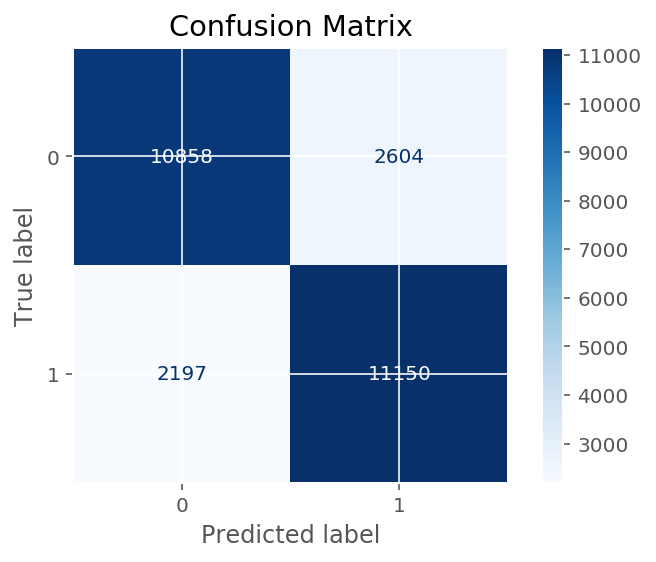

In [183]:
plot_confusion_matrix(lgbm, X_test, y_test, cmap=plt.cm.Blues) 
plt.title('Confusion Matrix')
plt.show()

> 테스트 데이터에 대해 맞추는 비율을 시각화 한것이다.

In [184]:
# fpr, tpr, _ = roc_curve(y_test, y_pred_roc_test)
# baseline_fpr, baseline_tpr, _ = roc_curve(y_test, [0] * len(y_test))

# plt.style.use("ggplot")
# plt.plot(fpr, tpr, label="Model")
# plt.plot(baseline_fpr, baseline_tpr, linestyle="--", label="Baseline")
# plt.xlabel("False Positive Rate", size=12)
# plt.ylabel("True Positive Rate", size=12)
# plt.title("Receiver Operating Characteristic")
# plt.legend(prop={"size": 12})
# plt.show()

## XGBoost

In [185]:
# params = {
#     # "xgbclassifier__booster": hp.choice("booster", ["gbtree","dart"]), #너무 오래걸림 dart 때문인듯
#     "xgbclassifier__max_depth": hp.quniform("max_depth", 2, 10, 1),
#     "xgbclassifier__n_estimators": hp.quniform("n_estimators", 200, 1000, 10),
#     "xgbclassifier__min_child_weight": hp.uniform("min_child_weight", 0, 15),
#     "xgbclassifier__colsample_bytree": hp.uniform("colsample_bytree", 0, 1.0),
#     "xgbclassifier__subsample": hp.uniform("subsample", 0, 1.0),
#     "xgbclassifier__learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
#     "xgbclassifier__scale_pos_weight": hp.uniform("scale_pos_weight", 0.5, 5),
#     "xgbclassifier__reg_lambda": hp.uniform("reg_lambda", 0, 10),
#     "xgbclassifier__reg_alpha": hp.uniform("reg_alpha", 0, 10),
#     "xgbclassifier__gamma": hp.uniform("gamma", 0, 10),
# }

In [186]:
# def get_pipe_xgb(params):
#     params["xgbclassifier__max_depth"] = int(
#         params["xgbclassifier__max_depth"]
#     )
#     params["xgbclassifier__n_estimators"] = int(
#         params["xgbclassifier__n_estimators"]
#     )  # max_depth는 정수형으로 변환해 줍니다.
#     pipe = make_pipeline(
#         OrdinalEncoder(),
#         SimpleImputer(strategy='constant', fill_value=0),
#         XGBClassifier(
#             objective="binary:logistic",
#             eval_metric="roc_auc",
#             random_state=2,
#             n_jobs=-1,
#             use_label_encoder=False

#         ),
#     )
#     pipe = pipe.set_params(**params)
#     return pipe


# def fit_and_eval_xgb(params):

#     pipe = get_pipe_xgb(params)  # 주어진 params로 파이프라인을 만들어 가져옵니다.
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
#     score = cross_val_score(pipe, X_train_enc, y_train, cv=skf, scoring="auc")
#     avg_cv_score = np.mean(score)
#     return {"loss": -avg_cv_score, "status": STATUS_OK}


# trials = (Trials()) # Trials() 객체를 fmin에 함께 넣어 실행하면, 실행되는 매 fit의 학습 정보 및 학습 결과가 해당 객체에 모두 저장됩니다.

# best_params = fmin(fn=fit_and_eval_xgb, trials=trials, space=params, algo=tpe.suggest, max_evals=20)  # max_evals 횟수만큼 하이퍼파라미터 조합을 탐색합니다.

In [187]:
# print("최적 하이퍼파라미터: ", trials.best_trial["misc"]["vals"])
# print("최적 f1: ", -trials.best_trial["result"]["loss"])

In [188]:
xgb = make_pipeline(
                    OrdinalEncoder(),
                    SimpleImputer(strategy='constant', fill_value=0),
                    XGBClassifier(
                        objective="binary:logistic",
                        eval_metric="auc",  # error = 1 - accuracy 지표를 사용해 평가합니다.
                        n_estimators = 900,
                        random_state=2,
                        n_jobs=-1,
                        max_depth=7,
                        learning_rate=0.0658908192290328,
                        reg_lambda= 4.064522267714798, # 디폴트 1. L2 정규화 규제 커질수록 오버피팅 방지, 너무크면 언더피팅
                        min_child_weight = 11.345654198486116,
                        scale_pos_weight = 1.8501866681062575, # 디폴트 1 balanced 역할을함 sum(negative cases) / sum(positive cases)
                        gamma = 6.116895981802964, #디폴트 0 감마 값이 클수록 알고리즘이 더 보수적
                        colsample_bytree = 0.5344986654514573, # 디폴트 1 column을 샘플링할 비율을 결정 영향없는듯
                        # max_leaves = 10, # 디폴트 0 영향없음 트리가 exact라 그런듯
                        subsample = 0.49733551405339904, # 디폴트 1  데이터(row)를 샘플링할 비율을 결정 영향없는듯
                        reg_alpha = 2.079414017217979, # 디폴트 0. L1 정규화 규제 커질수록 오버피팅 방지, 너무크면 언더피팅
                        # sparse feature 가 있거나 feature수가 지나치게 많을 때 효과적이다. 람다와 함께 튜닝
                        use_label_encoder=False
                        
                        )
)
xgb.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['augment0', 'augment1', 'augment2'],
                                mapping=[{'col': 'augment0',
                                          'data_type': dtype('O'),
                                          'mapping': TomeOfTraits1                 1
CelestialBlessing2            2
UrfsGrabBag1                  3
TradeSector                   4
BandOfThieves1                5
                           ... 
BruiserPersonalTrainerHR    191
LivingForgeHR               192
Diversify1                  193
Preparation1HR              194
NaN                          -2
Length: 195, dtype: int64},
                                         {'col': 'augment1',
                                          'data...
                               min_child_weight=11.345654198486116, missing=nan,
                               monotone_constraints='()', n_estimators=900,
                               n_jobs=-1, num_parallel_tree=

              precision    recall  f1-score   support

           0       0.88      0.72      0.79     10668
           1       0.76      0.90      0.83     10779

    accuracy                           0.81     21447
   macro avg       0.82      0.81      0.81     21447
weighted avg       0.82      0.81      0.81     21447

검증 정확도 0.8087378188091574
검증 f1_score 0.8256841747407785
검증 roc_auc score 0.9051021158536646
테스트 f1_score 0.8186885020298631
테스트 roc_auc score 0.9000320819577702


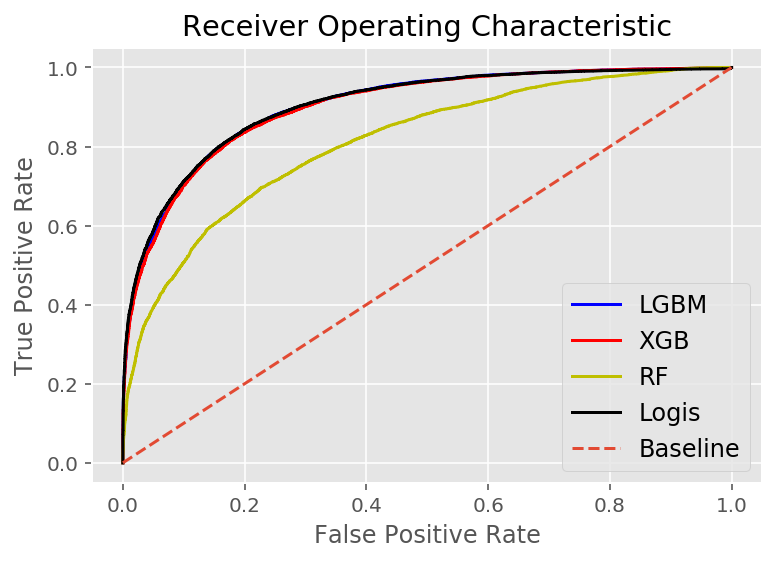

In [189]:
# xgboost 성능표
y_pred_xgb = xgb.predict(X_val)
y_pred_roc_xgb = xgb.predict_proba(X_val)[:,1]
y_pred_test_xgb = xgb.predict(X_test)
y_pred_roc_test_xgb = xgb.predict_proba(X_test)[:,1]
print(classification_report(y_val, y_pred_xgb))
print("검증 정확도", xgb.score(X_val, y_val))
print("검증 f1_score", f1_score(y_val, y_pred_xgb))
print("검증 roc_auc score", roc_auc_score(y_val, y_pred_roc_xgb))
print("테스트 f1_score", f1_score(y_test, y_pred_test_xgb))
print("테스트 roc_auc score", roc_auc_score(y_test, y_pred_roc_test_xgb))



fpr, tpr, _ = roc_curve(y_test, y_pred_roc_test)
fpr_2, tpr_2, _ = roc_curve(y_test, y_pred_roc_test_xgb)
fpr_3, tpr_3, _ = roc_curve(y_test, y_pred_roc_test_rf)
fpr_4, tpr_4, _ = roc_curve(y_test, y_pred_roc_test_logis)

baseline_fpr, baseline_tpr, _ = roc_curve(y_test, [0] * len(y_test))

plt.style.use("ggplot")
plt.plot(fpr, tpr, label="LGBM", color="b")
plt.plot(fpr_2, tpr_2, label="XGB", color="r")
plt.plot(fpr_3, tpr_3, label="RF", color="y")
plt.plot(fpr_4, tpr_4, label="Logis", color="black")
plt.plot(baseline_fpr, baseline_tpr, linestyle="--", label="Baseline")
plt.xlabel("False Positive Rate", size=12)
plt.ylabel("True Positive Rate", size=12)
plt.title("Receiver Operating Characteristic")
plt.legend(prop={"size": 12})
plt.show()

> Randomforest는 성능이 많이 떨어지고  XGBoost, Logistic, Lightgbm의 차이가 미미하므로 속도면에서 빠른 Lightgbm을 사용하기로함

## PermutationImportance & eli5(확인용) 
>유닛이나 증강체를 드랍해버리면 나중에 외부데이터를 입력받아 예측시 문제가 되므로 드랍하지않는다.(사실상 성능에 큰차이가 없음)

In [190]:
import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    lgbm.named_steps["lgbmclassifier"],  # model 소문자로 써야함
    scoring="roc_auc",  # metric f1으로하면 드랍컬럼이 많아짐
    n_iter=5,  # 다른 random seed를 사용하여 10번 반복
    random_state=42,
)

# 스코어를 다시 계산합니다.
X_val_enc = lgbm[0].transform(X_val) # 인코딩만 하는것
X_val_sim = lgbm[1].transform(X_val_enc) # 인코딩만 하는것
# SimpleImputer만 이럼
X_val_preprocessed = pd.DataFrame(X_val_sim, columns=X_val.columns)

permuter.fit(X_val_preprocessed, y_val)

PermutationImportance(estimator=LGBMClassifier(boost_from_average=False,
                                               colsample_bytree=0.41968205997262237,
                                               learning_rate=0.13564233477773605,
                                               metric='auc',
                                               min_child_weight=9.006801348726944,
                                               n_estimators=980,
                                               objective='binary',
                                               random_state=2,
                                               reg_alpha=0.7828881139207073,
                                               reg_lambda=73.43707959198584,
                                               scale_pos_weight=1.1001973705009573,
                                               subsample=0.9181105366746676),
                      random_state=42, scoring='roc_auc')

In [191]:
feature_names = X_val.columns.tolist() #  tolist() 함수를 이용해서 리스트로 만들수 있다.
permutation = pd.Series(permuter.feature_importances_, feature_names).sort_values()
# permutation.plot.barh()
# plt.title("Permutation Importance")

In [192]:
# 특성별 score을 확인합니다.
eli5.explain_weights( # show_weight랑 같음
    permuter,
    top=None,  # top n 지정 가능, None 일 경우 모든 특성
    feature_names=feature_names,  # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0379 ± 0.0024,TFT7_Yasuo
0.0314 ± 0.0010,TFT7_DragonPurple
0.0270 ± 0.0012,TFT7_Neeko
0.0192 ± 0.0010,TFT7_Pyke
0.0176 ± 0.0022,TFT7_Ornn
0.0156 ± 0.0011,TFT7_Talon
0.0143 ± 0.0006,TFT7_DragonGreen
0.0126 ± 0.0013,TFT7_TrainerDragon
0.0112 ± 0.0007,TFT7_Hecarim
0.0107 ± 0.0004,TFT7_DragonBlue


In [193]:
print("Top5 Important Features:")
p_i = sorted(
    list(zip(X_test.columns.tolist(), permuter.feature_importances_)),
    key=lambda x: x[1],
    reverse=True,
)
print(p_i[:5])

Top5 Important Features:
[('TFT7_Yasuo', 0.03786376045465791), ('TFT7_DragonPurple', 0.0313793297407543), ('TFT7_Neeko', 0.027025997446116667), ('TFT7_Pyke', 0.019164767116328706), ('TFT7_Ornn', 0.01759248156880482)]


>중요도를 보았을때 0인 값이 있지만 입력값으로 캐릭터나 증강체를 지울수는 없으므로 중요도를 확인하는 선에서 끝낸다. 상위에 야스오, 사이펜, 파이크, 니코, 오른이 분포하고있다.

## PDP plot

> 증강체의 경우 카디널리티가 높으므로 분석이 거의 불가하다. 아래는 분석가능한 특성인 캐릭터와 시너지에 대한 그래프다.

### Unit PDP plot

In [194]:
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 144

> 특성 상위 중요도에서 일반적으로 시너지가 신기루로 같아 같이 사용하는 다에야(신기루, 용)와 야스오(신기루), 탈론(암살자, 길드), 니코(비취, 형상변환자), 시오유(비취,용), 코르키(축제,포병),사이펜(속삭임, 난동꾼), 오른(폭풍,난동꾼)가 오버밸런스인가에 대해 pdpplot을 통해 시각화하고 패치방향의 결론을 내었다.

(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1cdfe5d2d30>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1cdfe572e80>})

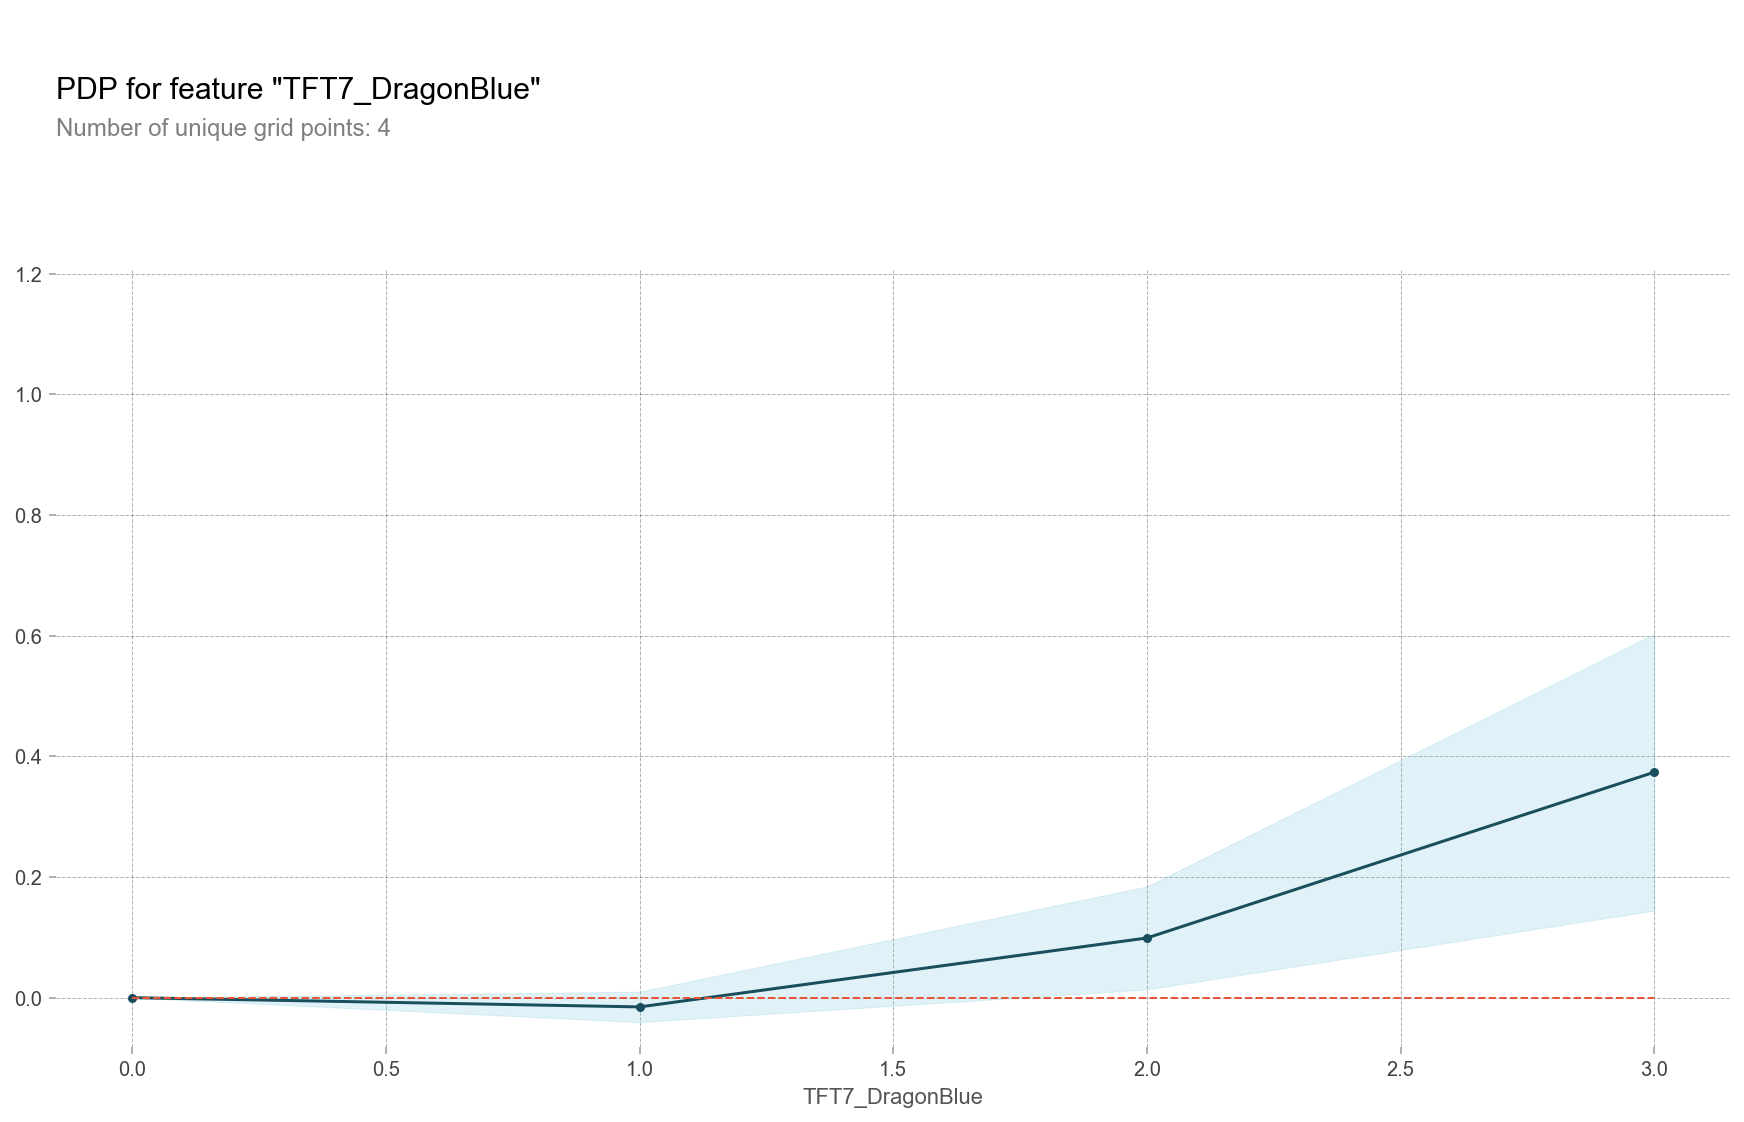

In [195]:
from pdpbox.pdp import pdp_isolate, pdp_plot

target_feature = "TFT7_DragonBlue"

isolated = pdp_isolate(
    model=lgbm,
    dataset=X_val_preprocessed,
    model_features=X_val.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=100,# default = 10
)
pdp_plot(isolated, feature_name=target_feature)

> 다에야의 경우 1성일때는 순방을 못하다가 2성일때부터 순방률이 올라가기 시작한다.

(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1cdfe57c8d0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1cdfe513320>})

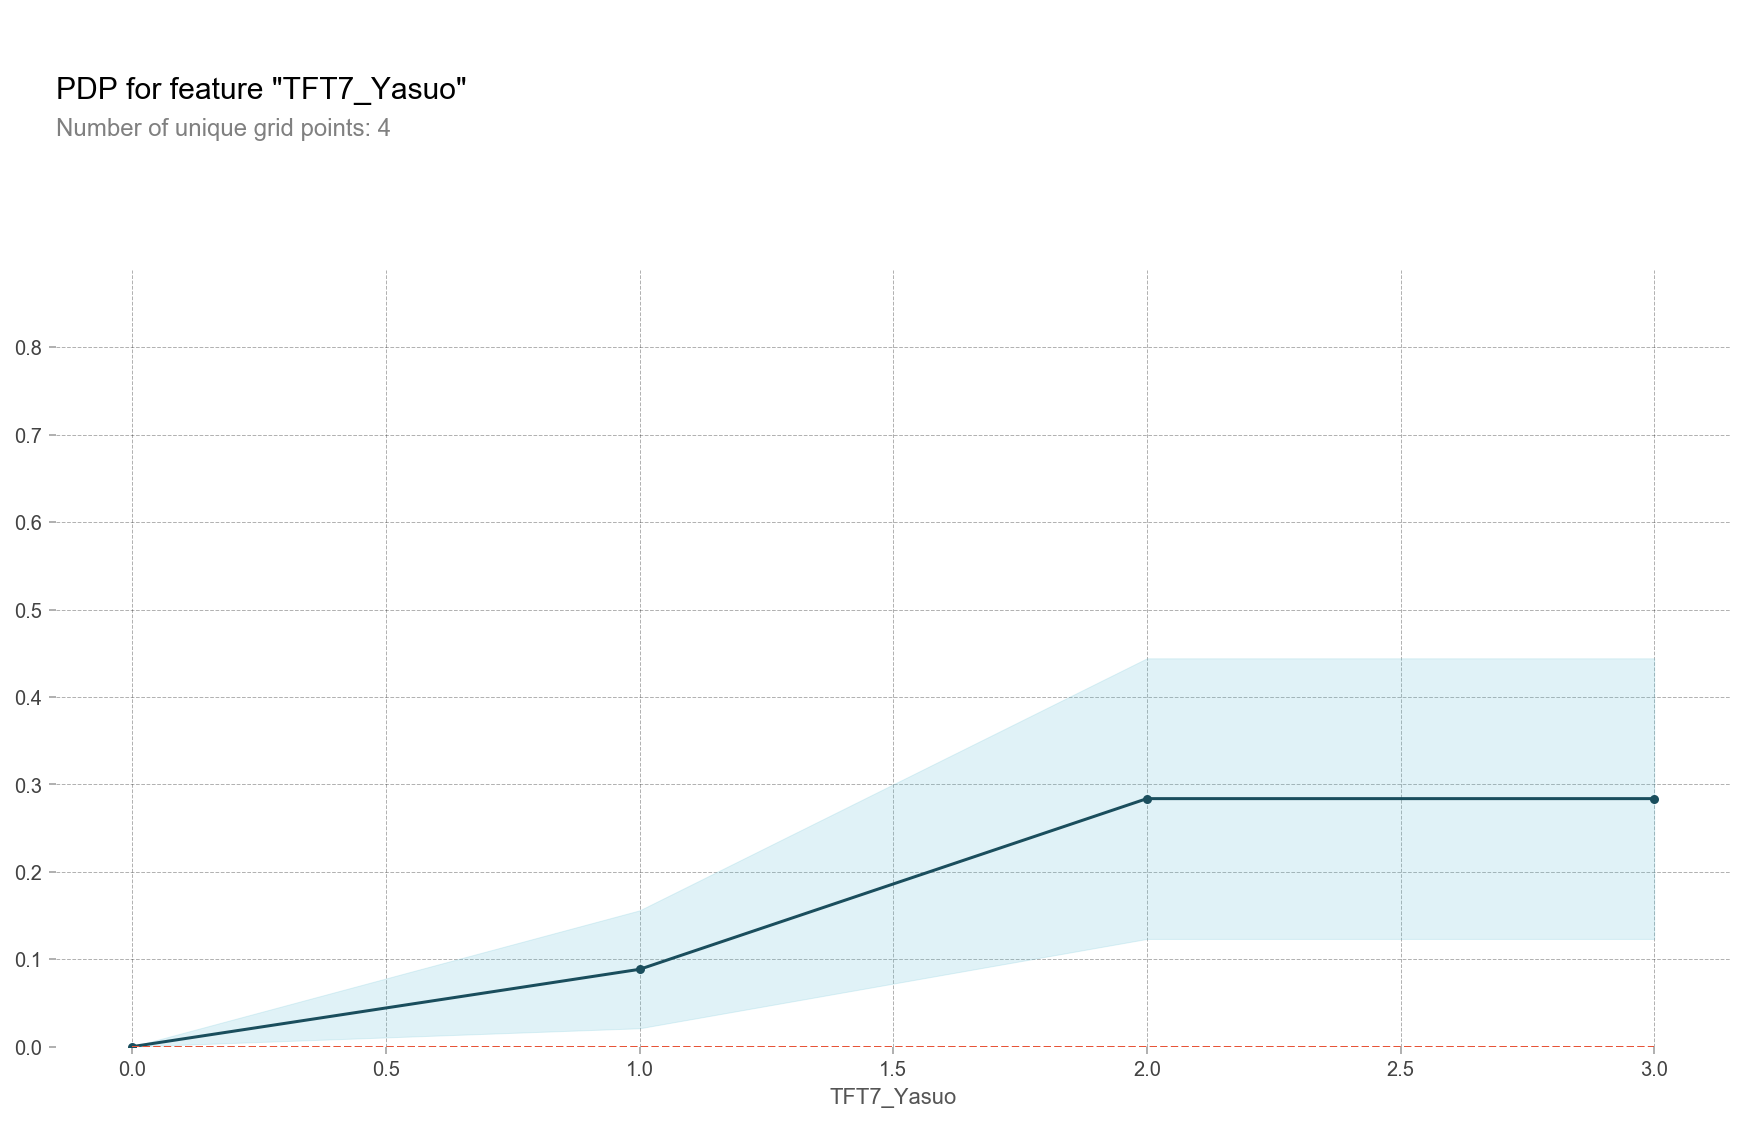

In [196]:
target_feature = "TFT7_Yasuo"

isolated = pdp_isolate(
    model=lgbm,
    dataset=X_val_preprocessed,
    model_features=X_val.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=300,# default = 10
)
pdp_plot(isolated, feature_name=target_feature)

(<Figure size 2160x1368 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1cdfe4ce828>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1cdfe4c2160>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1cdfe4a1ac8>}})

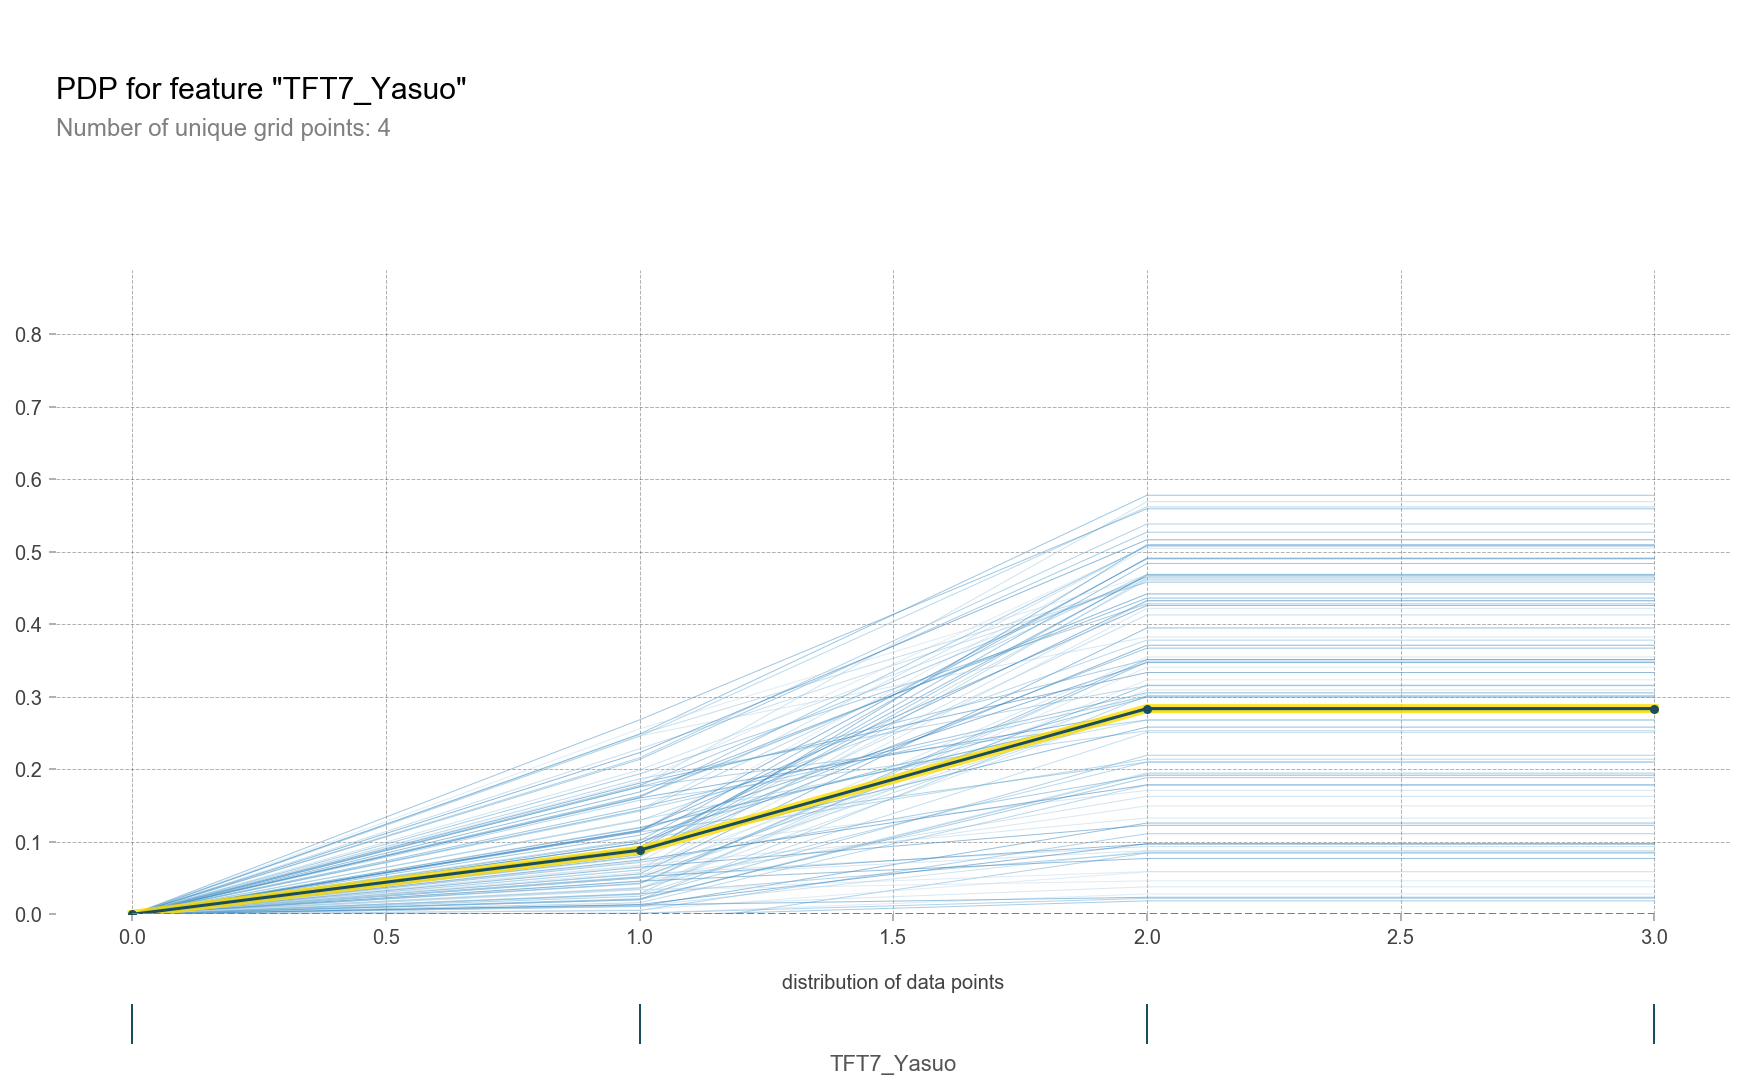

In [197]:
pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  # ICE plots
    frac_to_plot=100,  # float type을 입력하면 전체 데이터 갯수 중 plotting할 데이터 수의 비율이 됩니다. int type을 입력하면 데이터의 수가 됩니다.
    plot_pts_dist=True,
)

> 야스오 같은 경우 2성까지 순방률이 올라가고 이후부터는 일정한데 이유는 5코스트의 비용과 확률이 들어가기 때문에 3성작이 쉽지 않아 그런것으로 보인다.

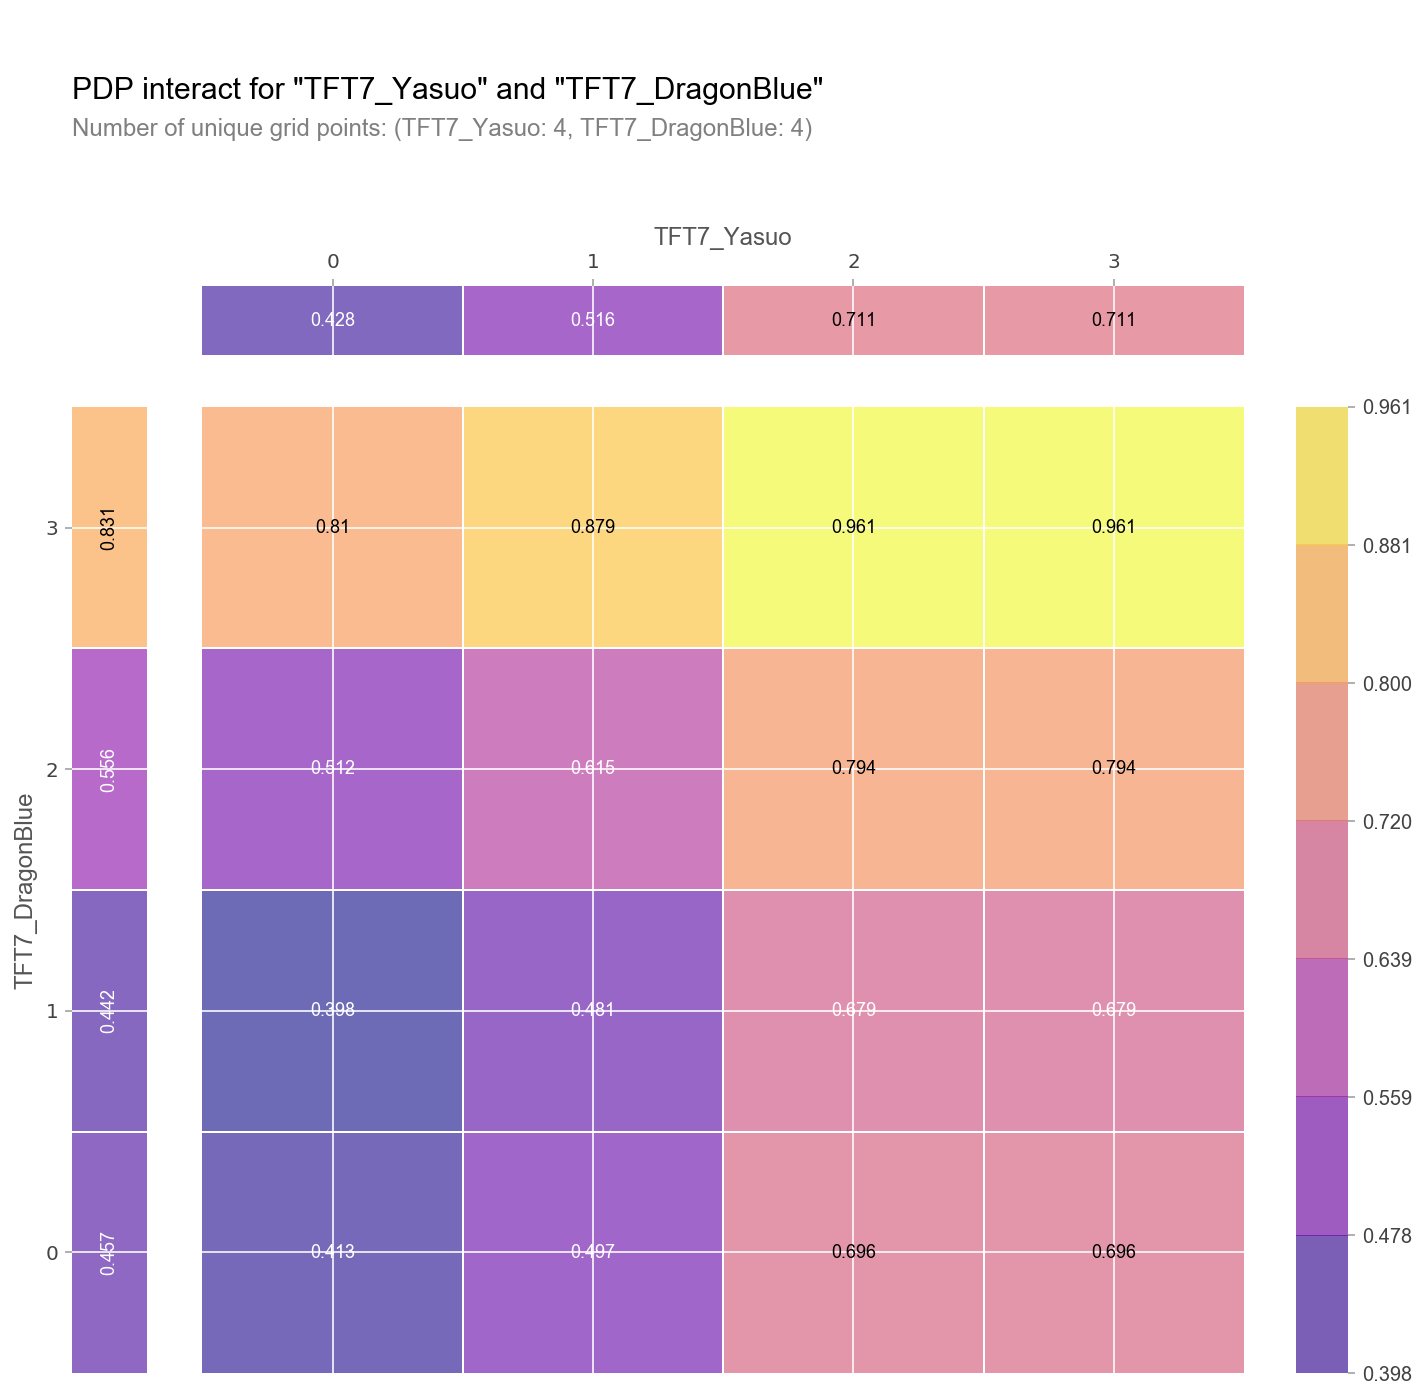

In [198]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

target_features = ["TFT7_Yasuo", "TFT7_DragonBlue"]

interaction = pdp_interact(
    model=lgbm,
    dataset=X_val_preprocessed,
    model_features=X_val.columns,
    features=target_features,
    cust_grid_points=[
        None,  # 첫 번째 특성인 marital-status에 대해서는 grid point를 지정해 주고,
        [0,1,2,3],  # 두 번째 특성인 age에 대해서는 자동 생성되는 grid point를 사용합니다.
    ],
)

axes = pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features,plot_pdp=True, plot_params={'cmap': 'plasma','inter_fill_alpha': 0.6}) # plot_pdp=True 각각의 특성에 대해 그려준다

> 둘다 2성일때부터 순방률이 확연히 올라가는 것을 볼 수 있다. 특이하게도 다에야를 1성을 쓰는것보다 아예 사용안하고 야스오만 사용하는 경우에 순방률이 더 높은것도 확인할수 있다. 이는 다른 특성인 전사를 활용하거나 벨류가 높기 때문에 시너지 상관없이 사용하는 경우로 보인다.

> 위의 결과로 신기루 시너지 활용을 안함에도 야스오가 보편적으로 매우 높은 순위방어율을 보유하기 때문에 야스오가 오버밸런스인것을 확인할 수 있다. 이를 통해 야스오 자체의 스텟 너프가 필요해 보인다.

In [199]:
interaction.pdp
pdp_pivoted_data = interaction.pdp.pivot_table(
    values="preds", columns=target_features[0], index=target_features[1]
)[
    ::-1
]  # 인덱스를 역순으로 만드는 slicing입니다
surface = go.Surface(
    x=pdp_pivoted_data.columns, y=pdp_pivoted_data.index, z=pdp_pivoted_data.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=target_features[0]),
        yaxis=dict(title=target_features[1]),
        zaxis=dict(title=target),
    )
)

fig = go.Figure(surface, layout)
fig.show()

> 아래는 오른, 사이펜, 시오유, 코르키, 니코, 탈론의 pdp plot이다.

(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1cdfe2990b8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1cdfe287400>})

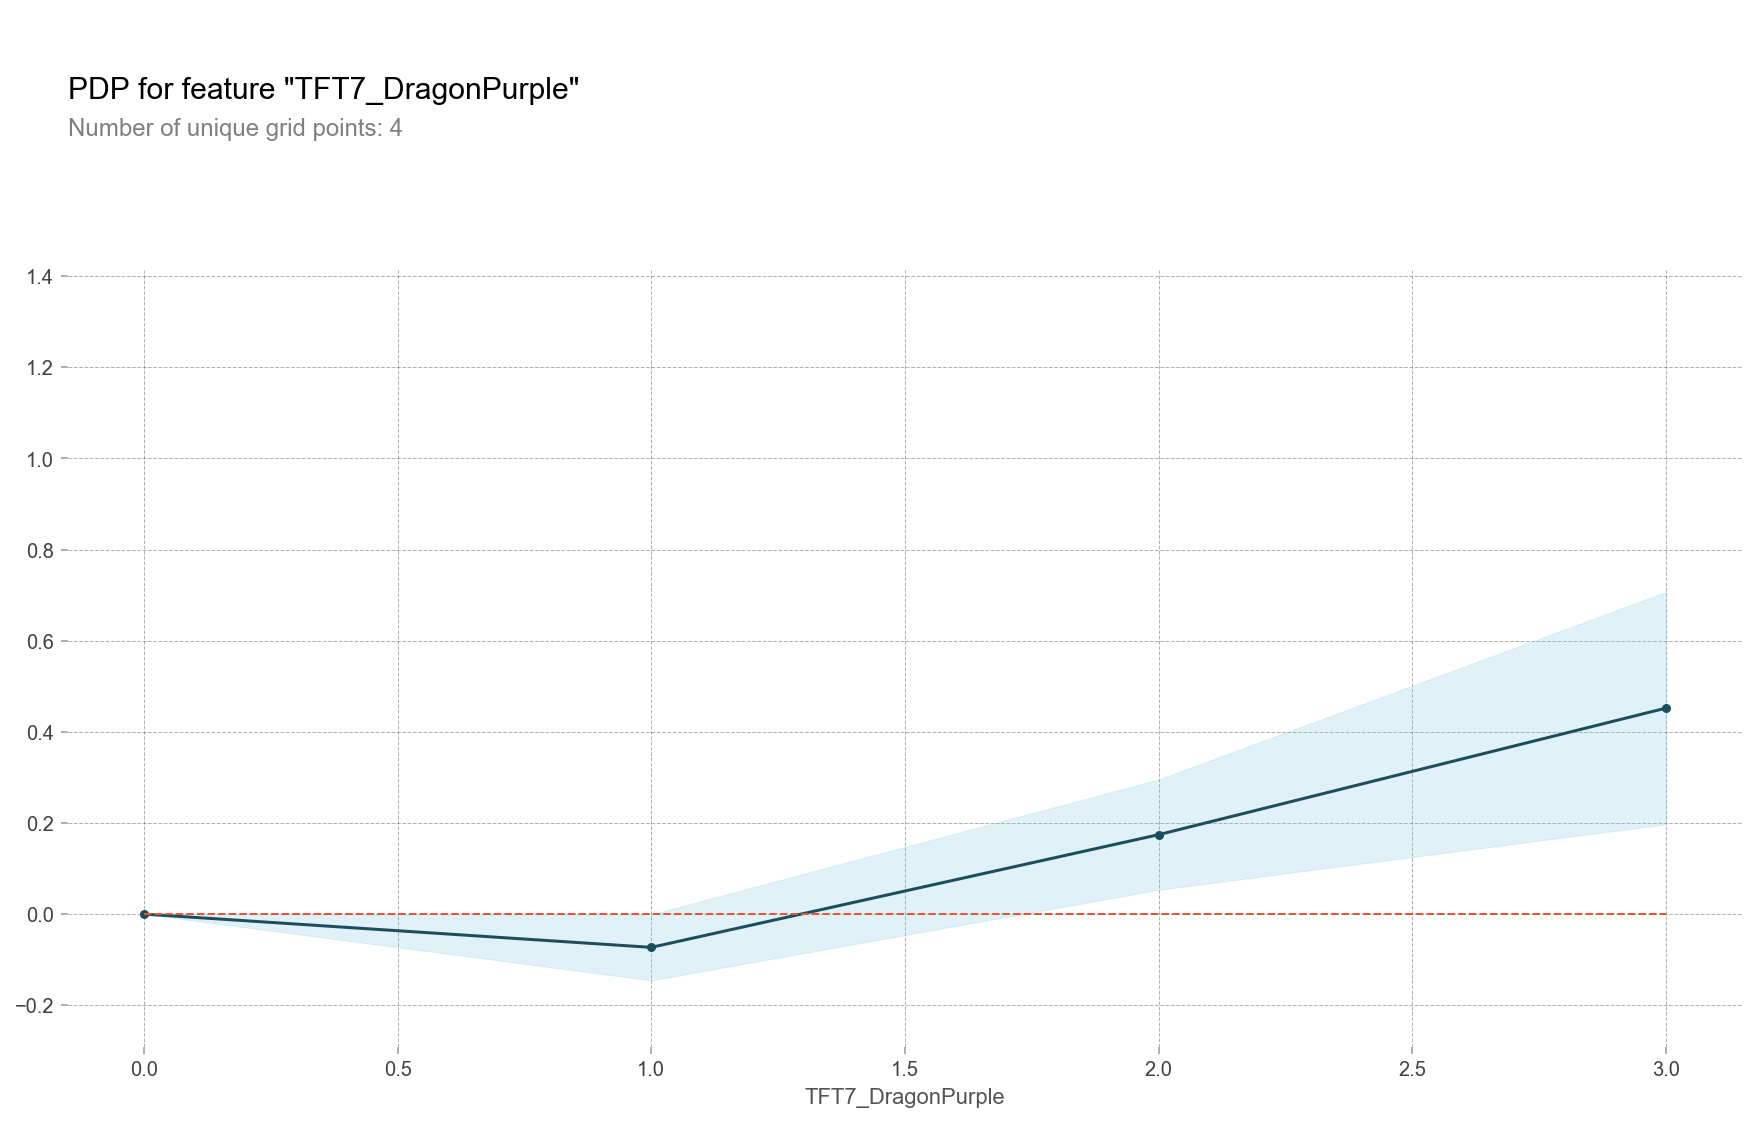

In [200]:
target_feature = "TFT7_DragonPurple"

isolated = pdp_isolate(
    model=lgbm,
    dataset=X_val_preprocessed,
    model_features=X_val.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=100,# default = 10
)
pdp_plot(isolated, feature_name=target_feature)

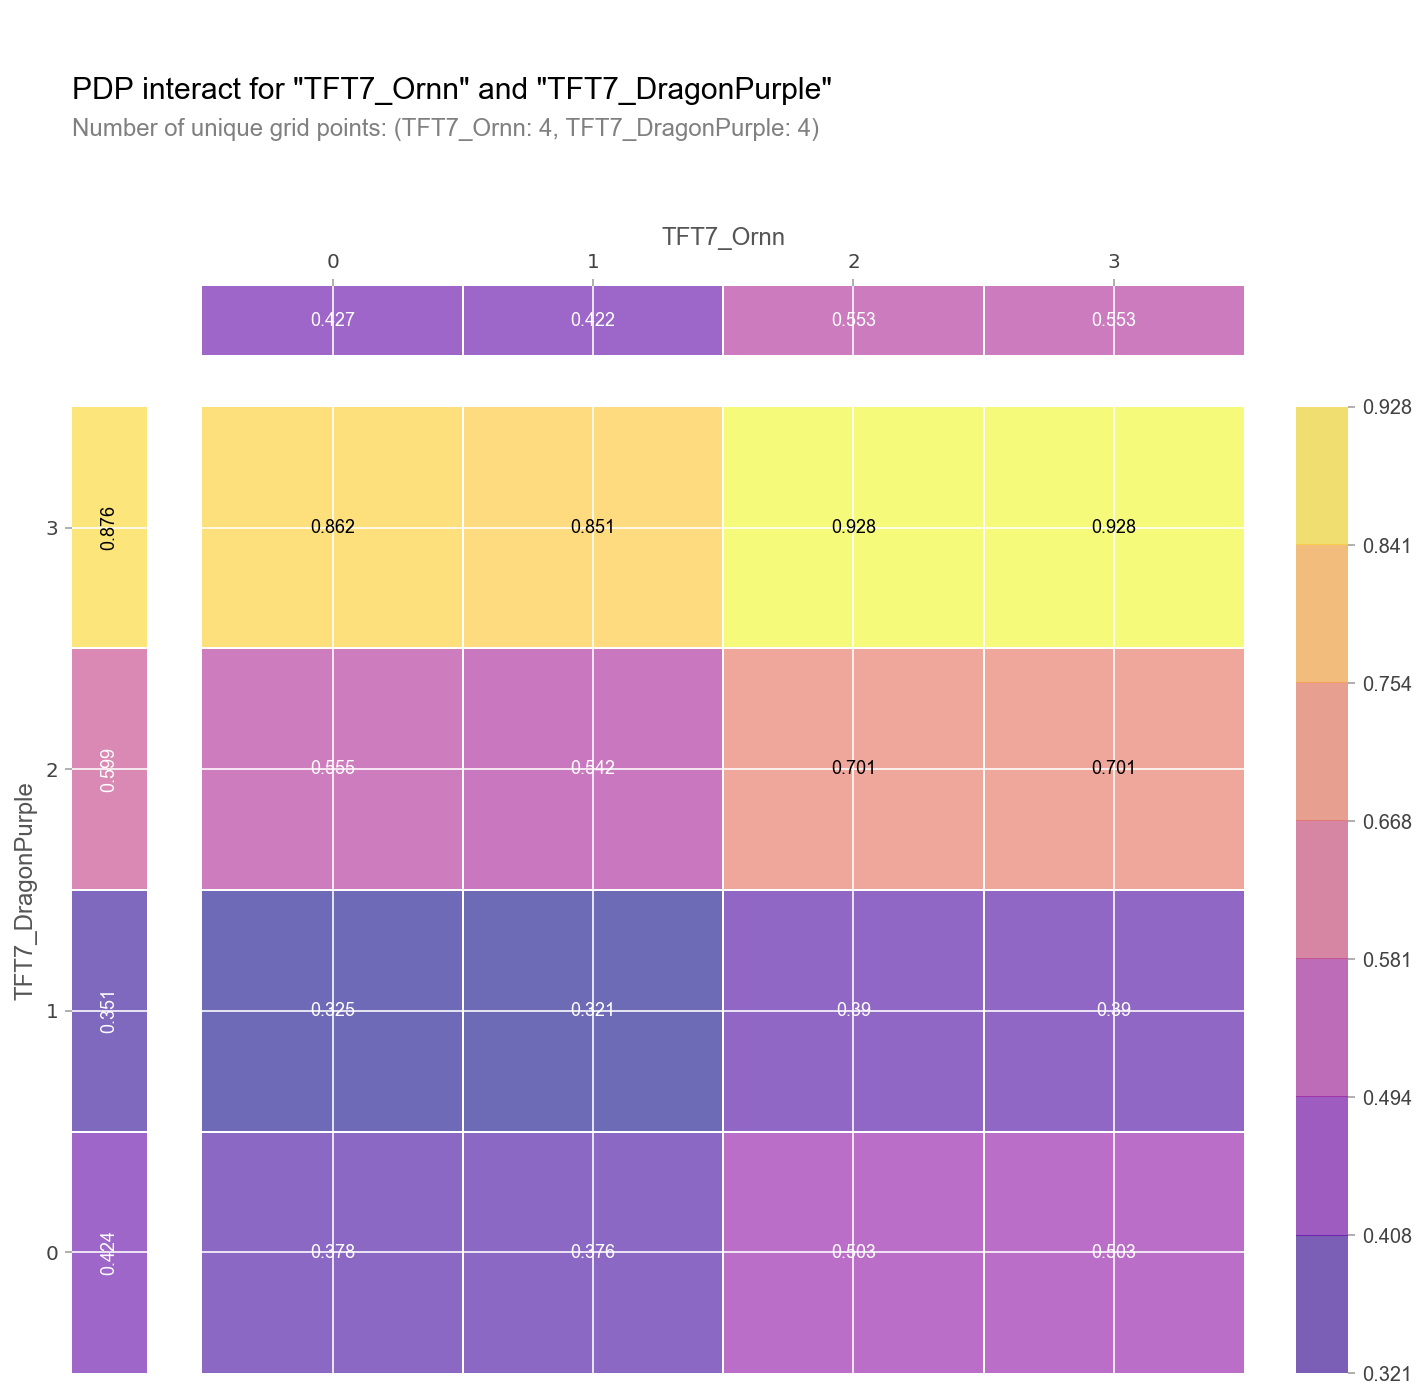

In [201]:
target_features = ["TFT7_Ornn", "TFT7_DragonPurple"]

interaction = pdp_interact(
    model=lgbm,
    dataset=X_val_preprocessed,
    model_features=X_val.columns,
    features=target_features,
    cust_grid_points=[
        None,  # 첫 번째 특성인 marital-status에 대해서는 grid point를 지정해 주고,
        [0,1,2,3],  # 두 번째 특성인 age에 대해서는 자동 생성되는 grid point를 사용합니다.
    ],
)

axes = pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features,plot_pdp=True, plot_params={'cmap': 'plasma','inter_fill_alpha': 0.6}) 

> 오른과 사이펜은 2성일때 매우 높은 순방률을 보인다. 그러나 사이펜이 순방률에 좀 더 영향을 주는것을 볼수있다. 사이펜의 시너지인 속삭임이나 난동꾼이 높은 순방률을 보이는것은 아니기때문에 사이펜을 너프하는 방향으로 패치를 진행한다.

(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1cdfe1673c8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1cdfe152ba8>})

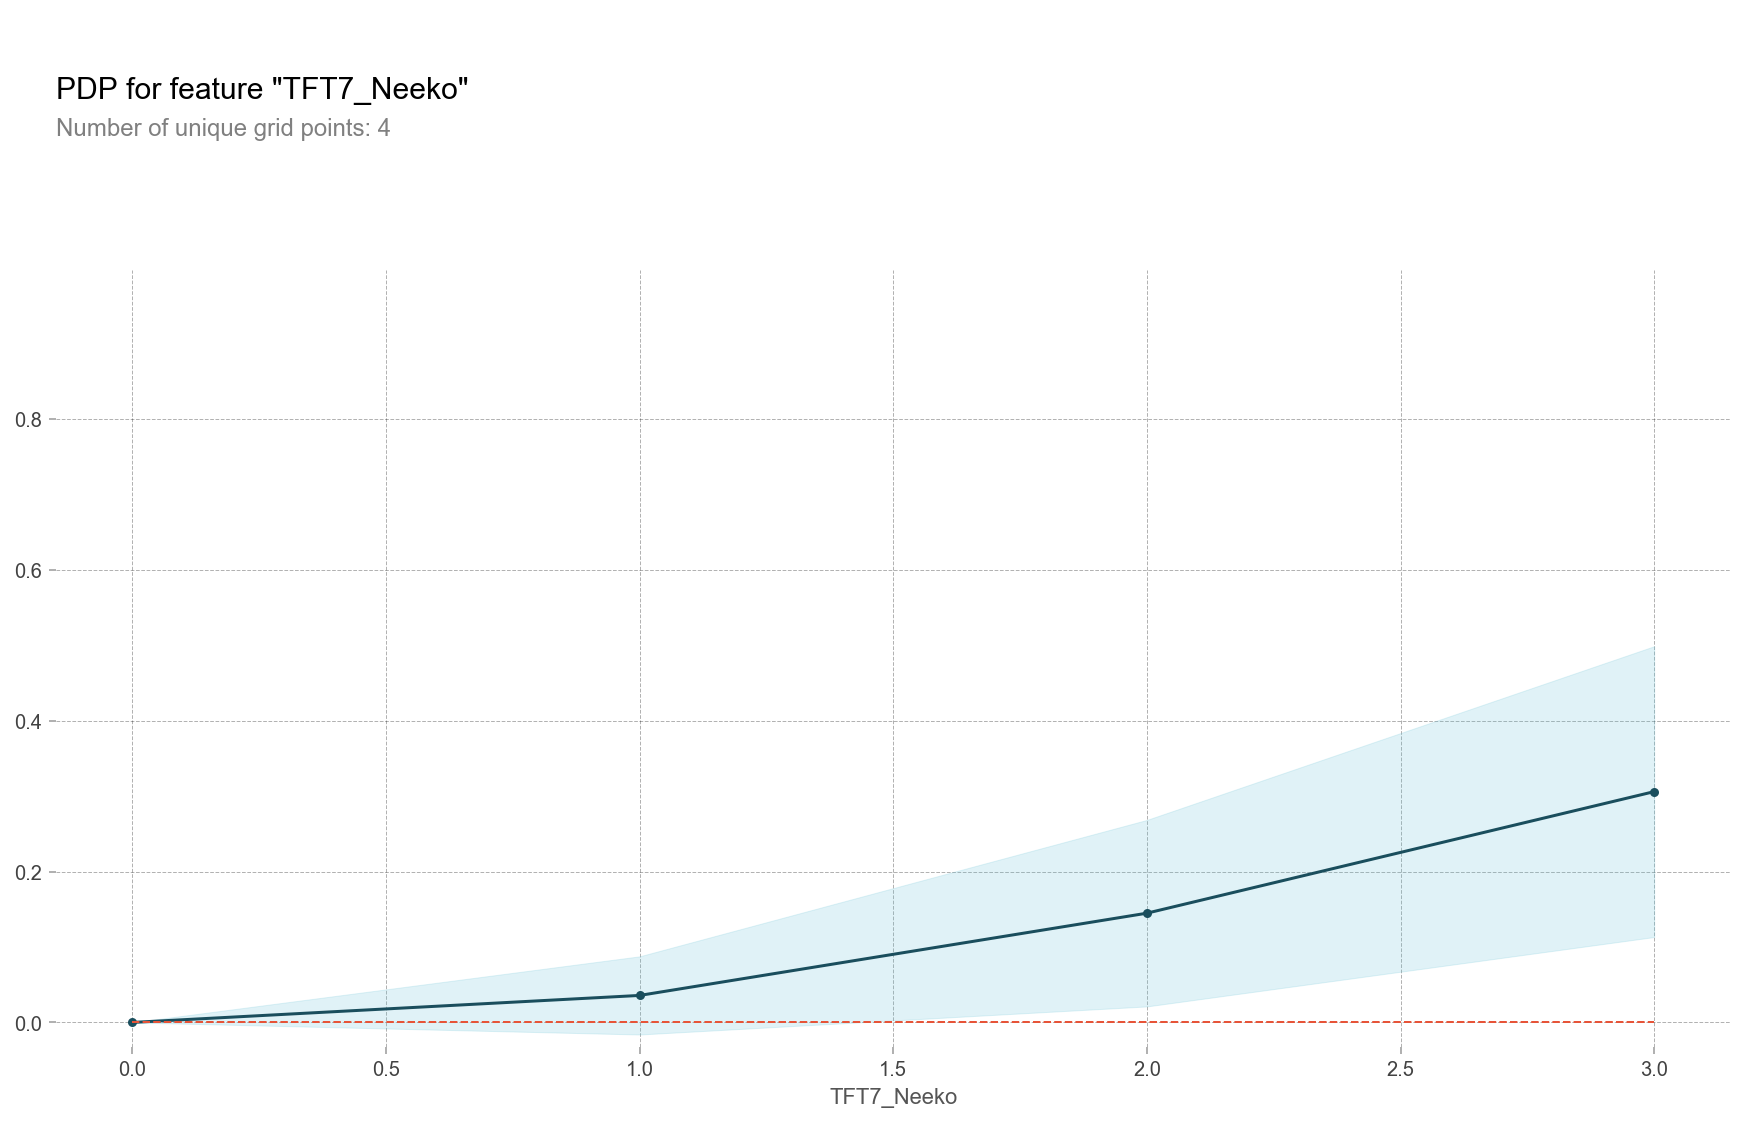

In [202]:
target_feature = "TFT7_Neeko"

isolated = pdp_isolate(
    model=lgbm,
    dataset=X_val_preprocessed,
    model_features=X_val.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=100,# default = 10
)
pdp_plot(isolated, feature_name=target_feature)

(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1cdfde9e1d0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1cdfde5db38>})

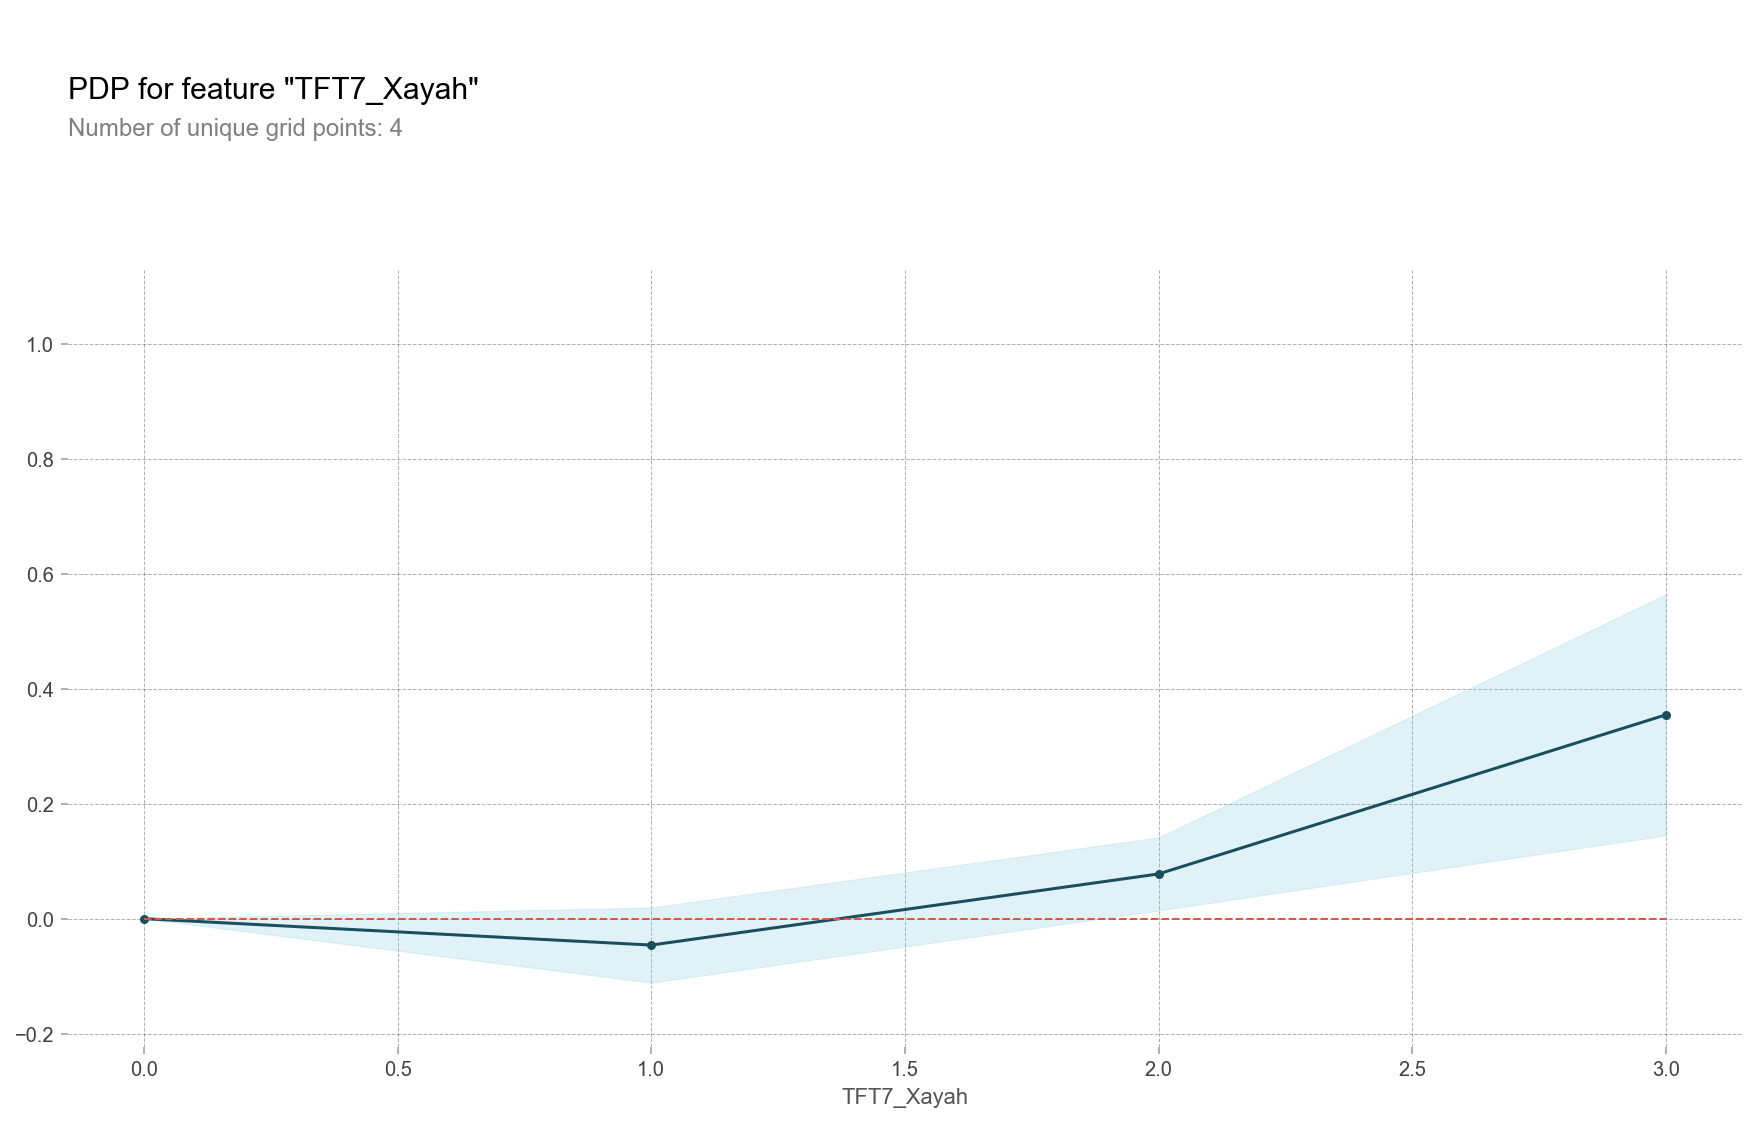

In [209]:
target_feature = "TFT7_Xayah"

isolated = pdp_isolate(
    model=lgbm,
    dataset=X_val_preprocessed,
    model_features=X_val.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=100,# default = 10
)
pdp_plot(isolated, feature_name=target_feature)

(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1cdfded2400>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1cdfdf22240>})

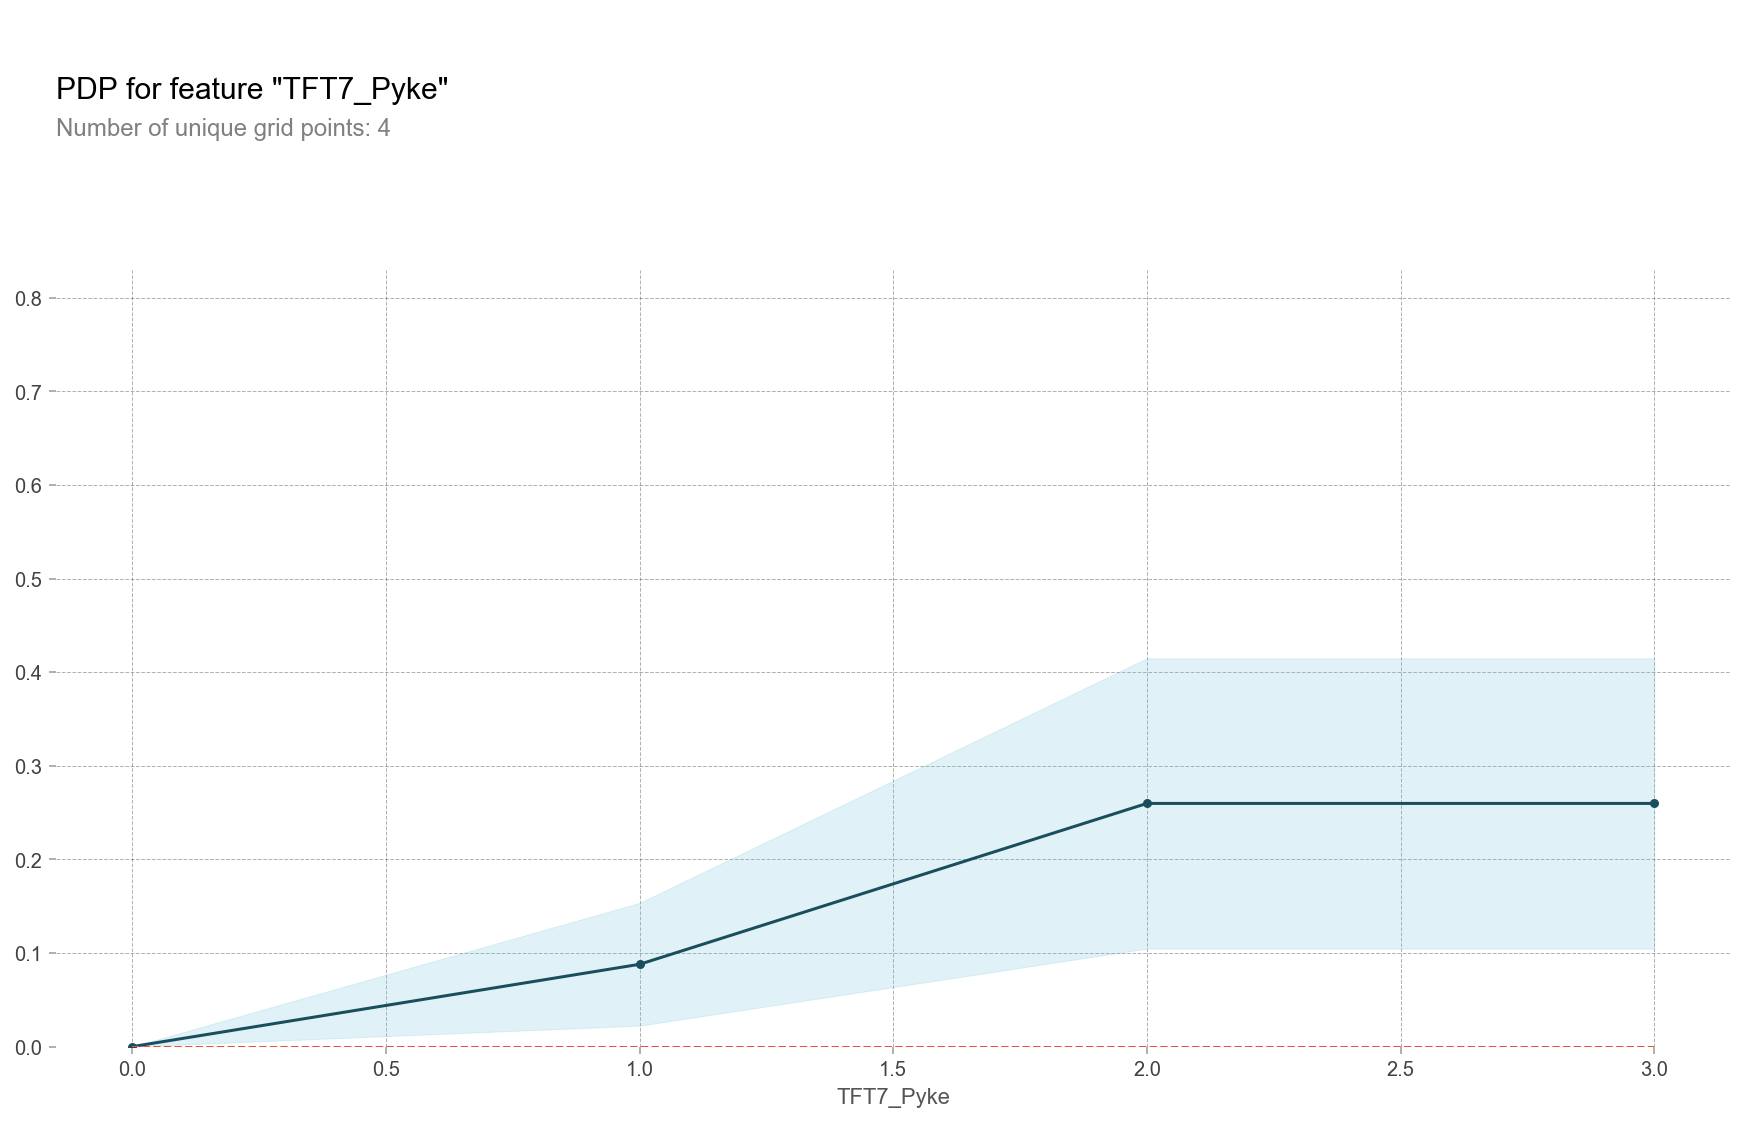

In [210]:
target_feature = "TFT7_Pyke"

isolated = pdp_isolate(
    model=lgbm,
    dataset=X_val_preprocessed,
    model_features=X_val.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=100,# default = 10
)
pdp_plot(isolated, feature_name=target_feature)

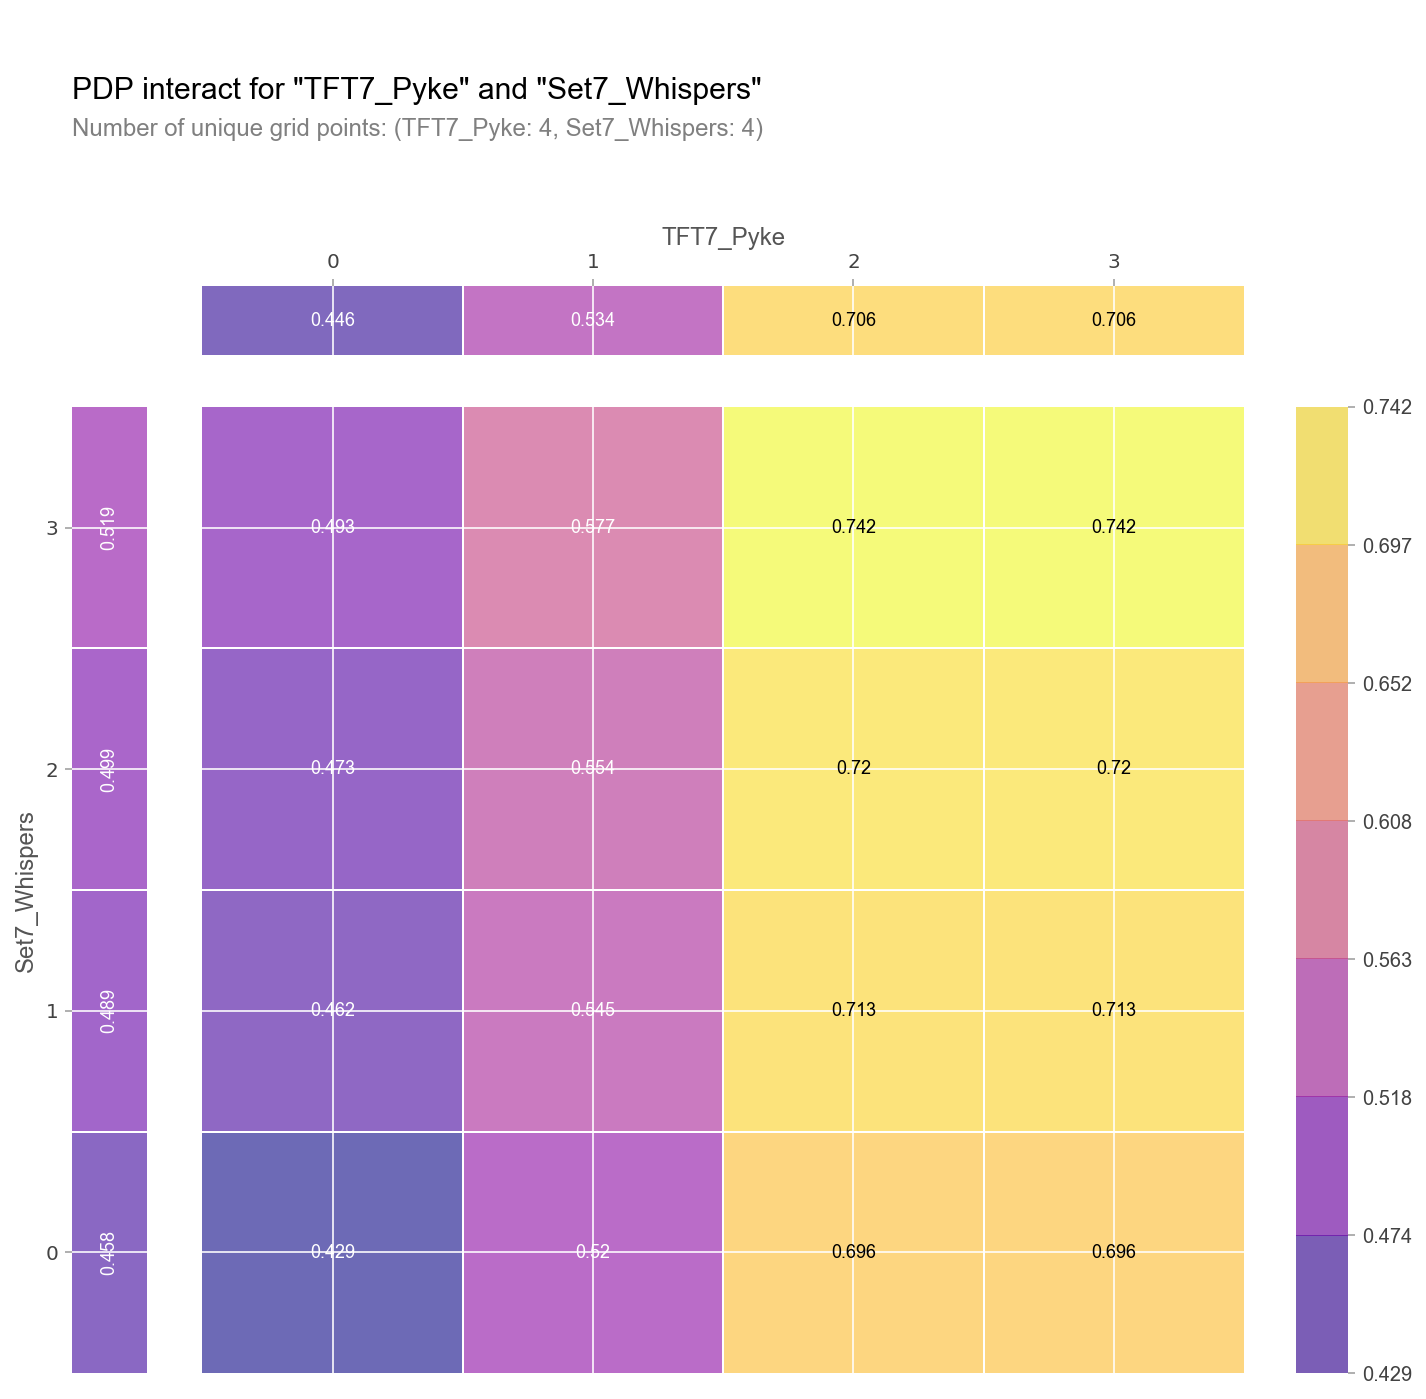

In [212]:
target_features = ["TFT7_Pyke", "Set7_Whispers"]

interaction = pdp_interact(
    model=lgbm,
    dataset=X_val_preprocessed,
    model_features=X_val.columns,
    features=target_features,
    cust_grid_points=[
        [0,1,2,3],  # 첫 번째 특성인 marital-status에 대해서는 grid point를 지정해 주고,
        [0,1,2,3],  # 두 번째 특성인 age에 대해서는 자동 생성되는 grid point를 사용합니다.
    ],
)

axes = pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features,plot_pdp=True, plot_params={'cmap': 'plasma','inter_fill_alpha': 0.6}) 

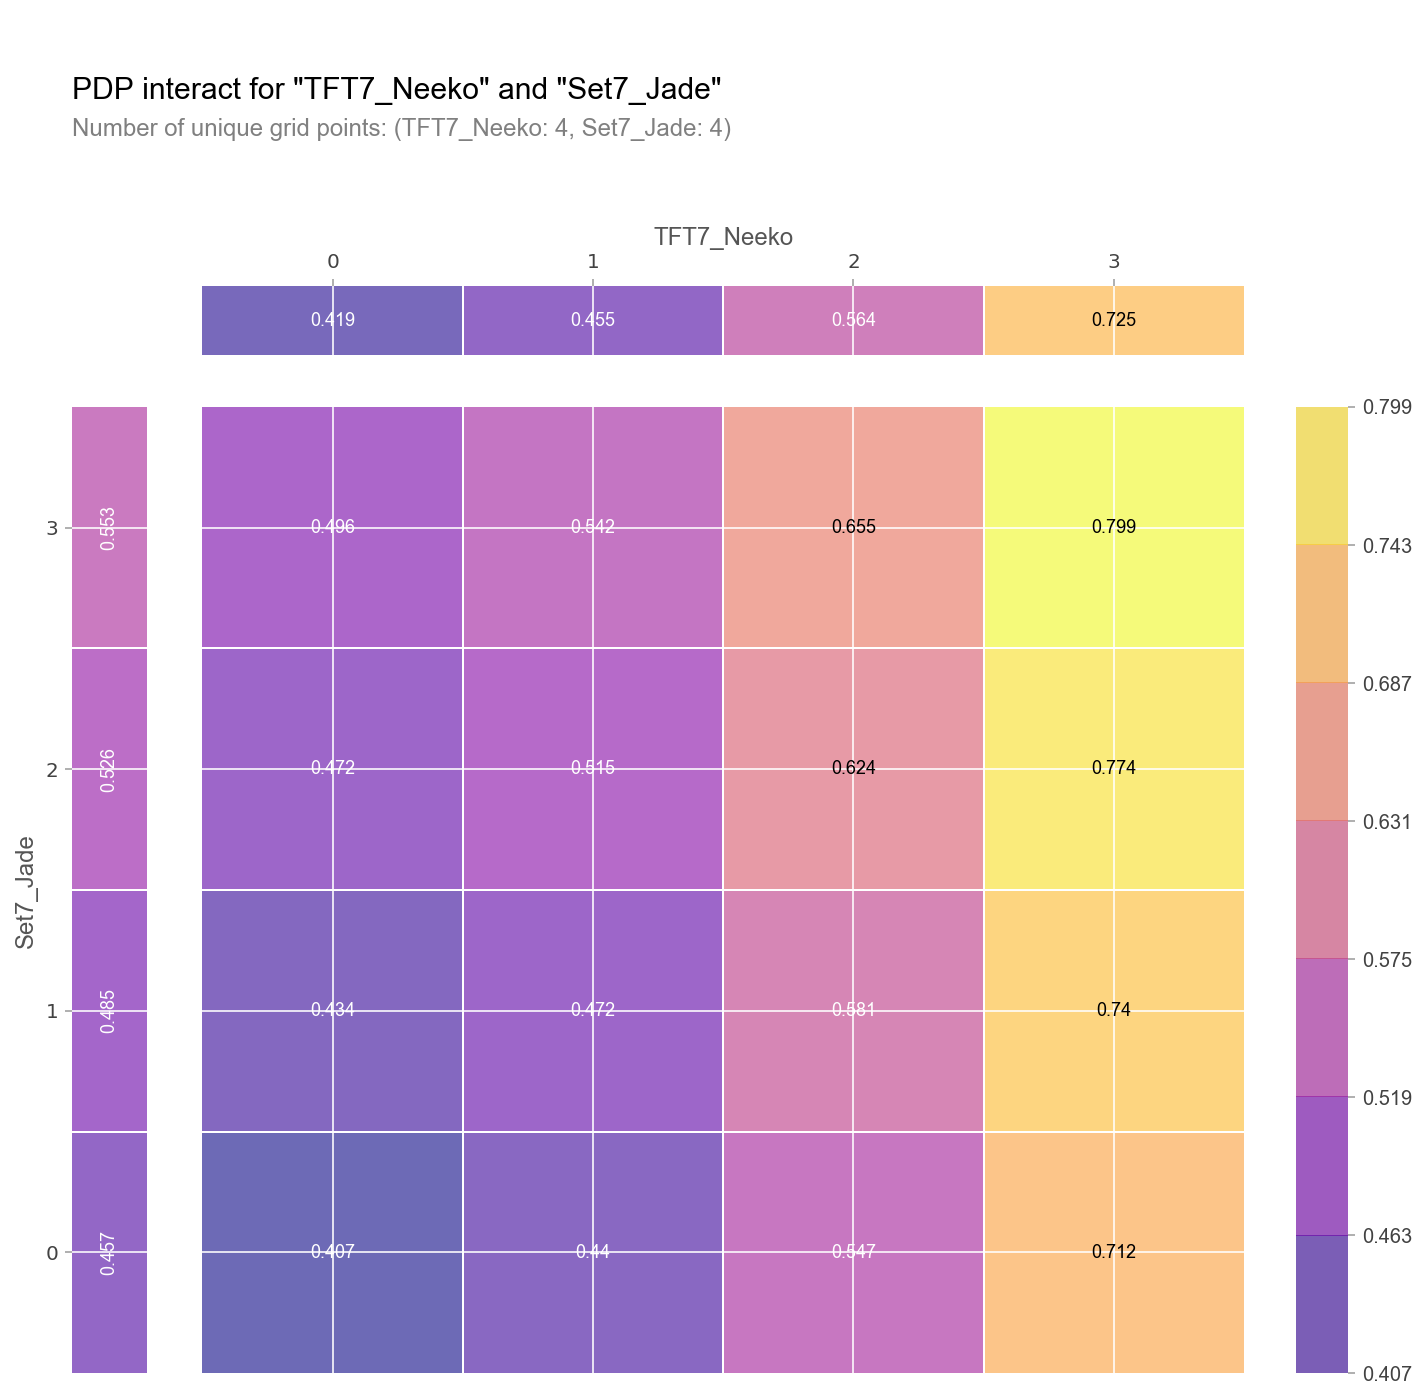

In [203]:
target_features = ["TFT7_Neeko", "Set7_Jade"]

interaction = pdp_interact(
    model=lgbm,
    dataset=X_val_preprocessed,
    model_features=X_val.columns,
    features=target_features,
    cust_grid_points=[
        None,  # 첫 번째 특성인 marital-status에 대해서는 grid point를 지정해 주고,
        [0,1,2,3],  # 두 번째 특성인 age에 대해서는 자동 생성되는 grid point를 사용합니다.
    ],
)

axes = pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features,plot_pdp=True, plot_params={'cmap': 'plasma','inter_fill_alpha': 0.6}) 

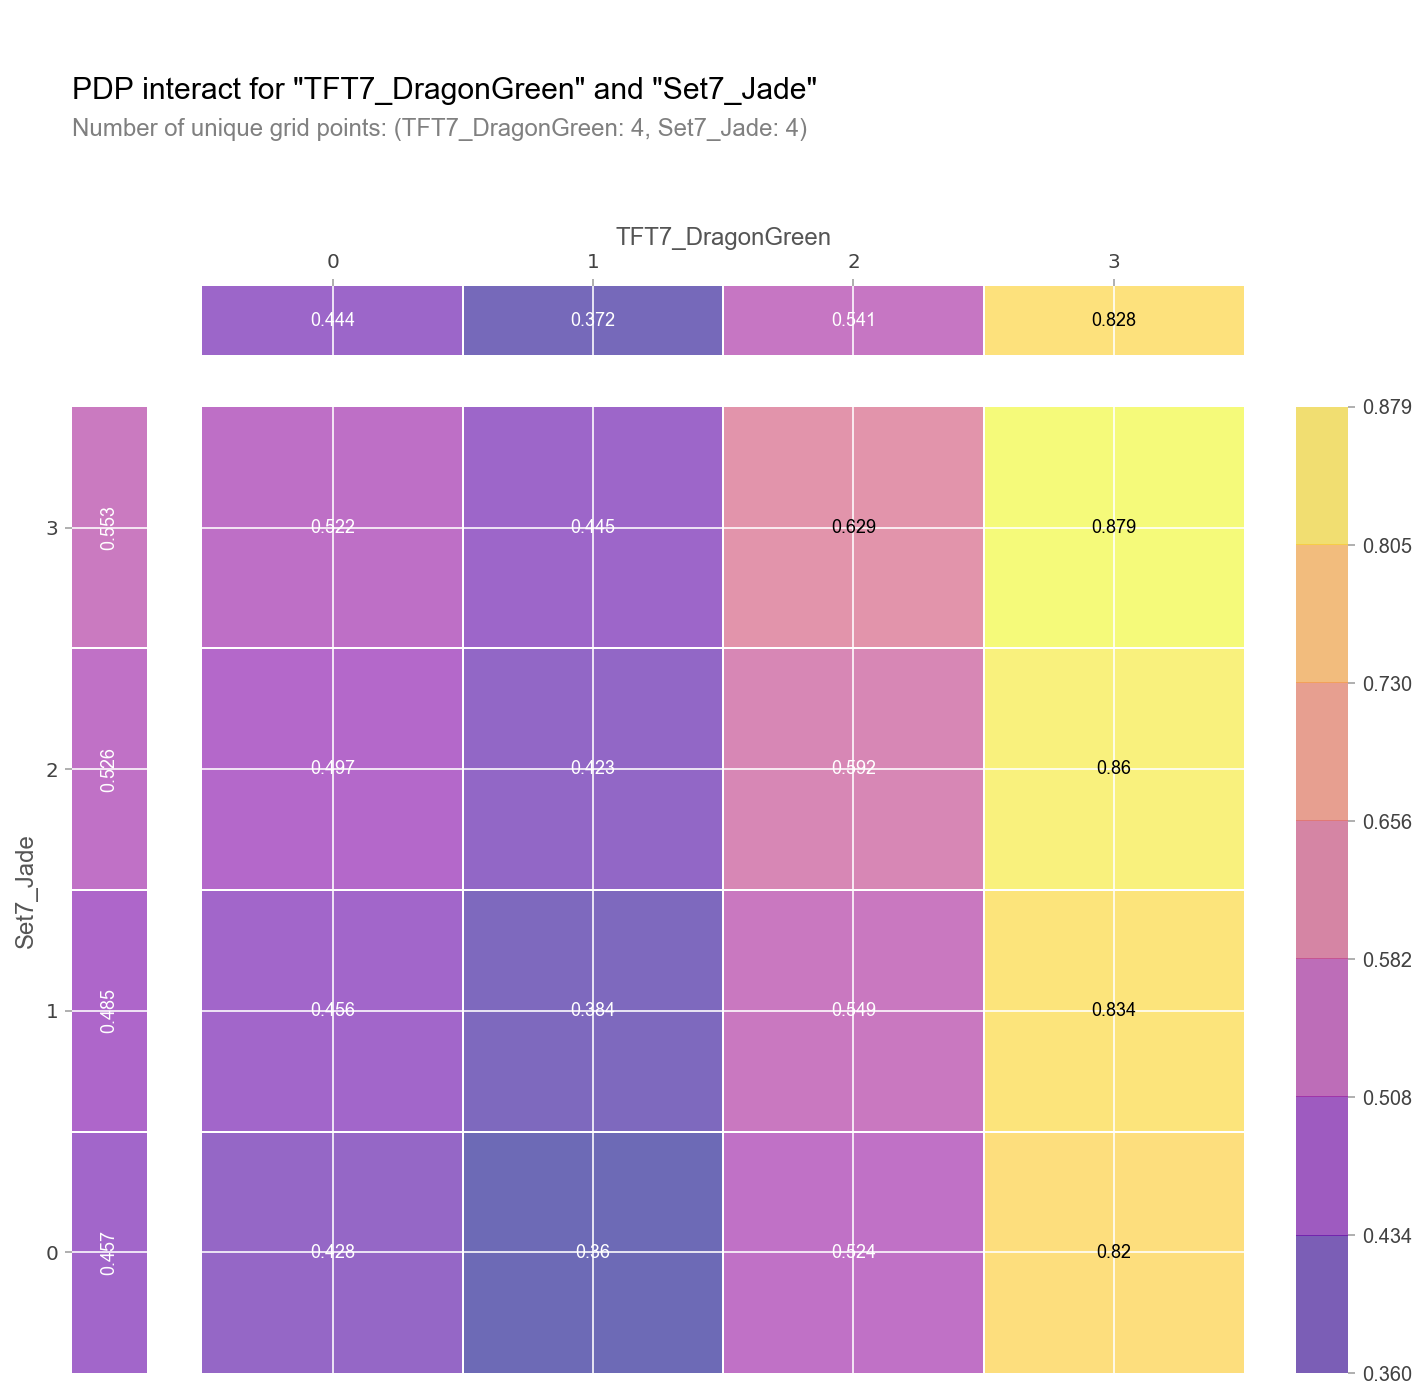

In [204]:
target_features = ["TFT7_DragonGreen", "Set7_Jade"]

interaction = pdp_interact(
    model=lgbm,
    dataset=X_val_preprocessed,
    model_features=X_val.columns,
    features=target_features,
    cust_grid_points=[
        [0,1,2,3],  # 첫 번째 특성인 marital-status에 대해서는 grid point를 지정해 주고,
        [0,1,2,3],  # 두 번째 특성인 age에 대해서는 자동 생성되는 grid point를 사용합니다.
    ],
)

axes = pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features,plot_pdp=True, plot_params={'cmap': 'plasma','inter_fill_alpha': 0.6}) 

>  니코의 경우 니코 유무에 따라 순방률이 꾸준히 증가하고 시오유는 유무보다 시너지가 더 중요하게 작용하는것을 알수 있다. 따라서 니코를 너프하고 시오유는 유지하는 방향으로 패치한다.

(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1cdfddf5588>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1cdfddd48d0>})

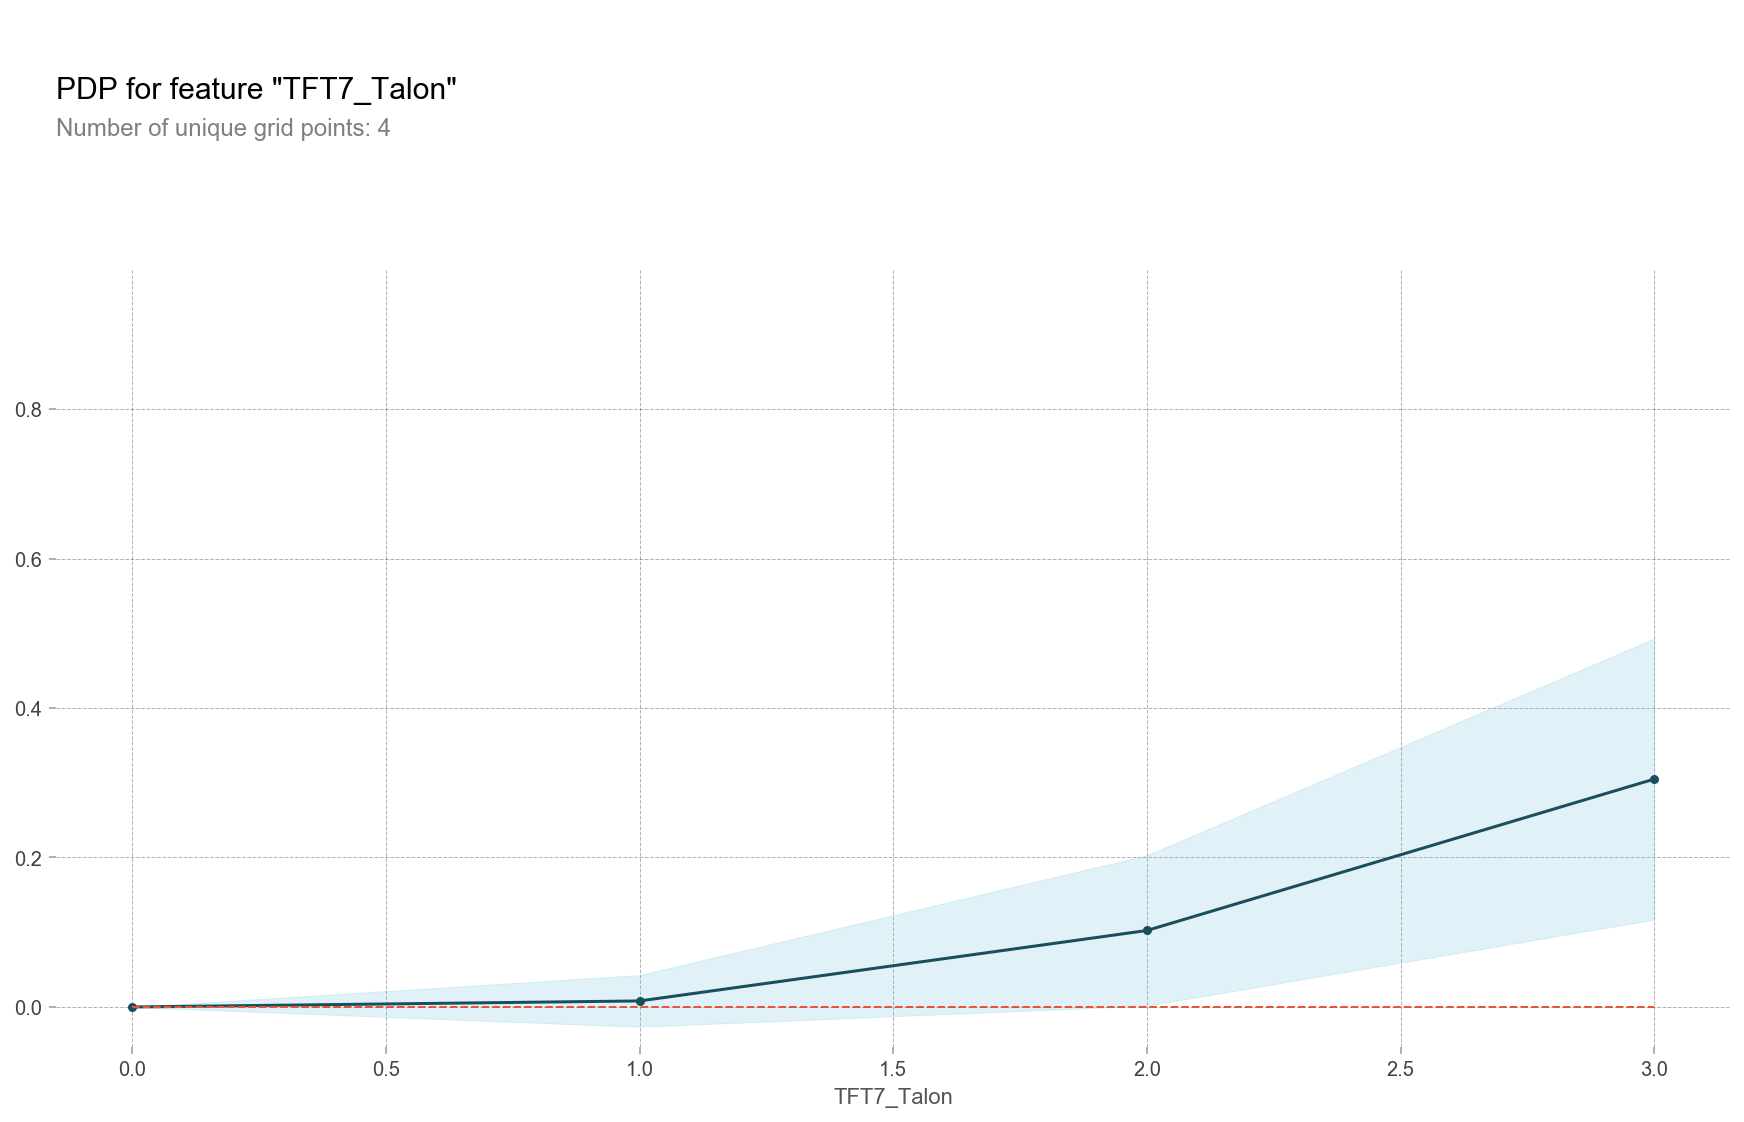

In [205]:
target_feature = "TFT7_Talon"

isolated = pdp_isolate(
    model=lgbm,
    dataset=X_val_preprocessed,
    model_features=X_val.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=100,# default = 10
)
pdp_plot(isolated, feature_name=target_feature)

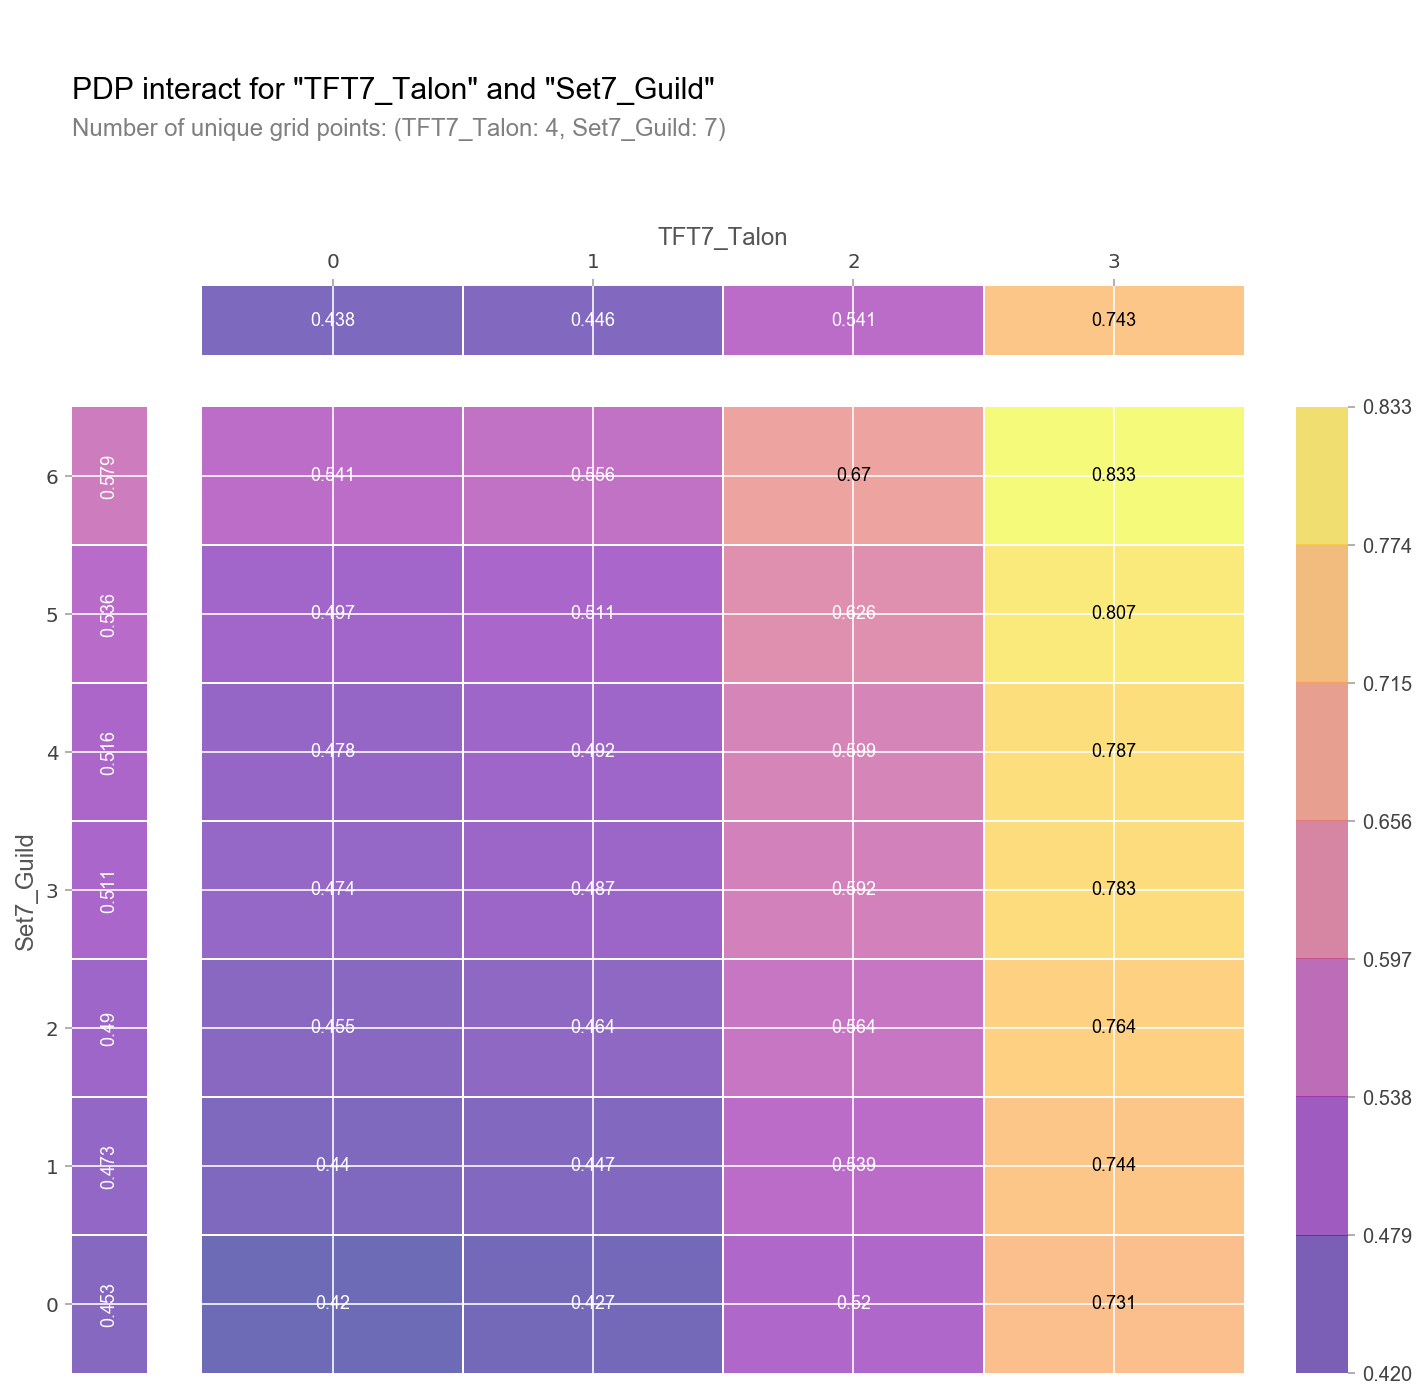

In [206]:
target_features = ["TFT7_Talon", "Set7_Guild"]

interaction = pdp_interact(
    model=lgbm,
    dataset=X_val_preprocessed,
    model_features=X_val.columns,
    features=target_features,
    cust_grid_points=[
        None,  # 첫 번째 특성인 marital-status에 대해서는 grid point를 지정해 주고,
        [0,1,2,3,4,5,6],  # 두 번째 특성인 age에 대해서는 자동 생성되는 grid point를 사용합니다.
    ],
)

axes = pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features,plot_pdp=True, plot_params={'cmap': 'plasma','inter_fill_alpha': 0.6}) 

> 탈론의 유무보단 시너지에 따라 달라지며 앞서 말했듯이 길드 시너지를 가진 유닛이나 이를 활용하는 유닛의 순방률도 높으므로 길드 시너지를 너프하는 패치를 진행하여야 한다. 이는 길드를 사용하는 자야 자체의 간접너프로 이어진다.

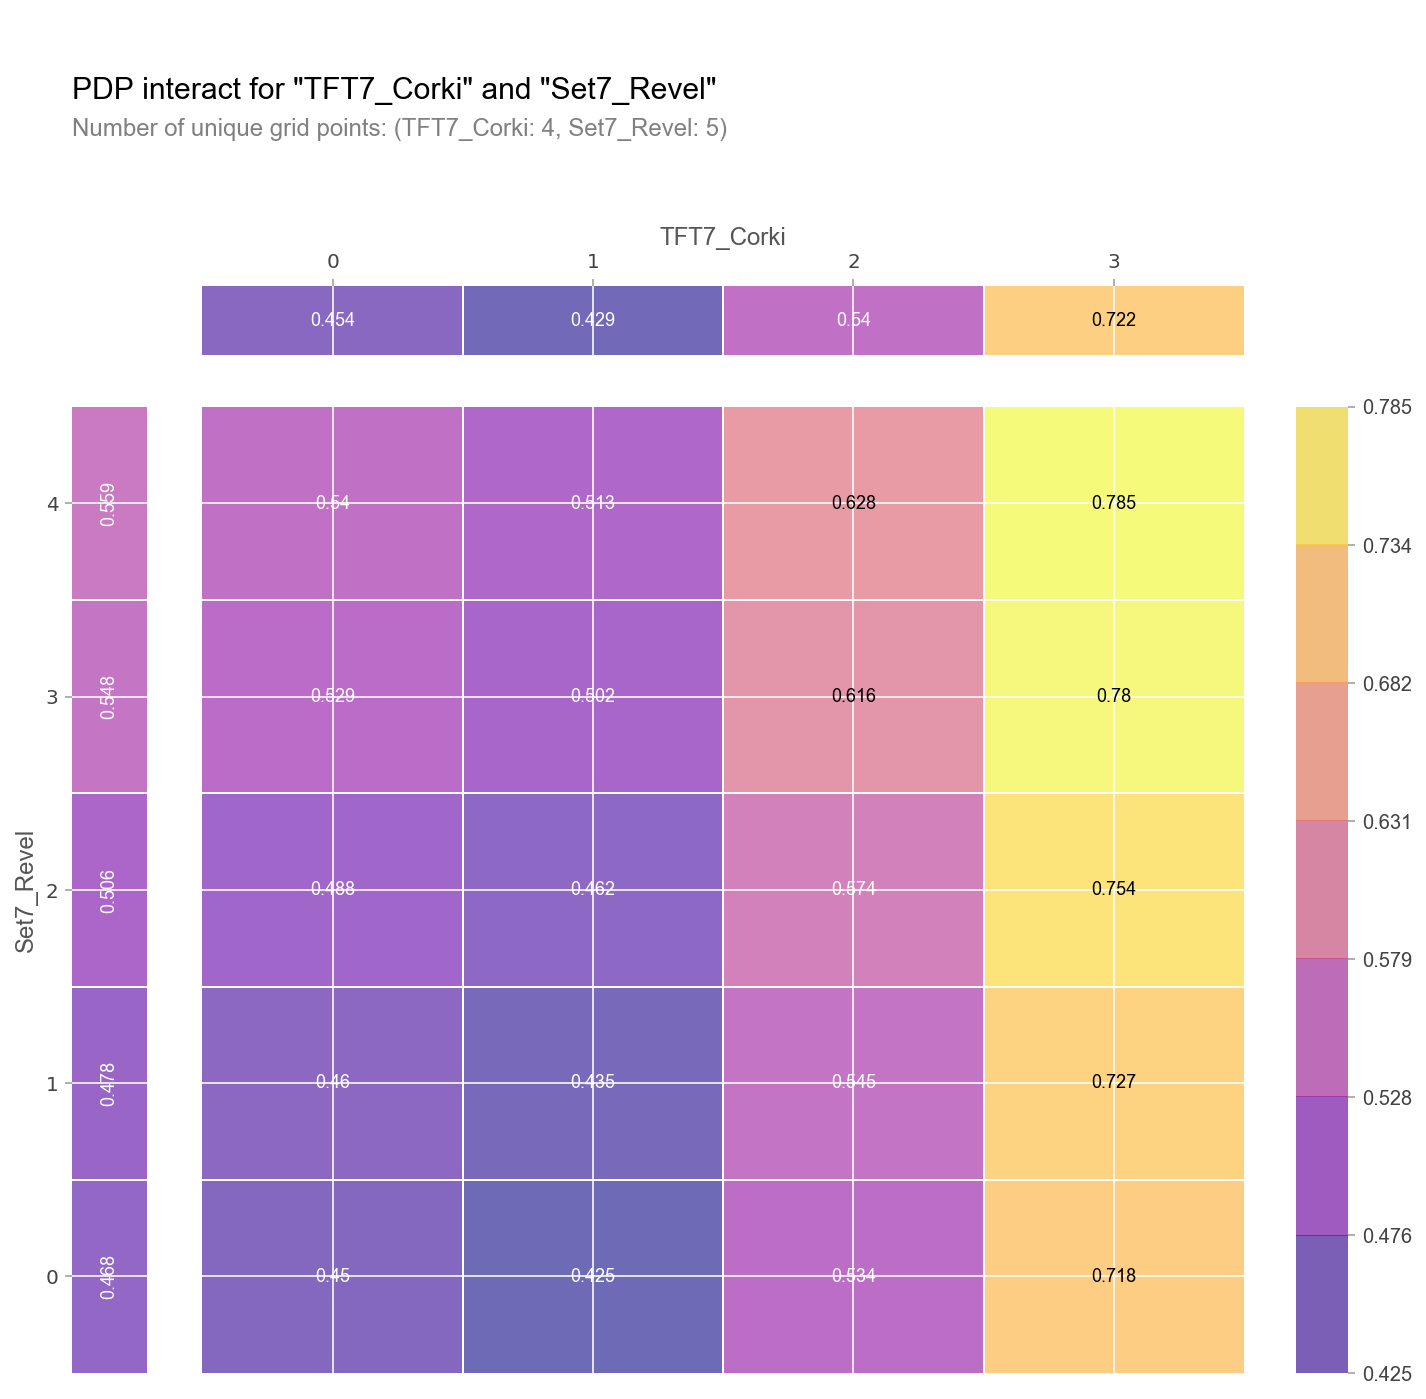

In [207]:
target_features = ["TFT7_Corki", "Set7_Revel"]

interaction = pdp_interact(
    model=lgbm,
    dataset=X_val_preprocessed,
    model_features=X_val.columns,
    features=target_features,
    cust_grid_points=[
        [0,1,2,3],  # 첫 번째 특성인 marital-status에 대해서는 grid point를 지정해 주고,
        [0,1,2,3,4],  # 두 번째 특성인 age에 대해서는 자동 생성되는 grid point를 사용합니다.
    ],
)

axes = pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features,plot_pdp=True, plot_params={'cmap': 'plasma','inter_fill_alpha': 0.6}) 

> 코르키 유무보다는 축제 시너지의 영향을 더 많이 받는다. 앞에서 시각화로 살펴보았듯이 축제시너지 너프가 필요하다.

# 결론

- 순위방어율로 살펴본 결과 몇개의 시너지와 유닛이 높은 수치를 가지고 있다.

1. 위 결과를 토대로 유닛은 야스오, 니코, 사이펜을 너프한다.  

>야스오 - 스텟 너프(시너지 상관없이 자체 순방율이 높음)  
사이펜 - 시너지의 영향보다 유닛 자체가 쌔므로 이를 너프하고 시너지를 버프하는쪽으로 패치  
오른- 사이펜 너프로인한 간접너프
탈론- 길드너프 (자야 간접 너프)  
코르키 - 축제 너프(코르키 보다는 시너지가 더 큰 영향을 미침)  
시오유 - 유지(니코 너프로 인한 간접 너프)  

2. 시너지는 축제, 길드, 빛비늘을 너프한다.  
>빛비늘-9빛비늘만 너프  
길드 - 길드 자체 시너지를 너프 길드를 사용하는 조합들이 높은 순방률을 보임  
축제 - 축제 시너지 자체가 순방률이 높음 따라서 너프  